# Assignment 4: Movie Review Analysis [50 Pt]

In this assignment, we will build a recurrent neural network to work with sequential text data, specificially, movie review data to identify the reviewer sentiment. In the process of completing this assignment, you will:
    
1. Clean and process text data for machine learning.
2. Perform tokenization of text data.
3. Understand and implement a word-level recurrent neural network.
4. Implement batching of text data using a DataLoader before training a recurrent neural network.
5. Understand how to apply pretrained models for transfer learning in natural language processing projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your Colab file in case your solutions are cut off, **please make sure that your Colab file is publicly accessible at the time of submission.**

In [17]:
# TO BE COMPLETED

# https://colab.research.google.com/drive/1mNLntWURqtvmEQOUL0DClCIVxZ6lwNaR?usp=sharing

# PART A - Sentiment Analysis

In this part we will construct a world-level LSTM model for identifying positive and negative reviews. This will be done in a similar way to what was shared in the preparation code for Assignment 4.

In [18]:
# load standard modules/libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# load special modules/libraries
import os
import warnings
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter
import string
import re
from tqdm  import tqdm

# load pytorch modules/libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader


[nltk_data] Downloading package stopwords to /home/souren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Part 1. Data Cleaning [5 pt]

We will be using the "IMDB Movie Review Dataset" provided on the course website. Download "IMDB Dataset.csv" into your Colab workspace.

### Part (i) [1pt EXPLORATORY]

Open up the file in Python, and examine some examples of positive and negative reviews. Comment on the quality of the data and any challenges you foresee in working with these data. Pick one example of a positive review and one of a negative review to support your comments.

In [20]:
# download IMDB review data

# load dataset
df = pd.read_csv("IMDB Dataset.csv")

# process into data and labels
X = df['review'].values
y = df['sentiment'].values


In [21]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<font color=red> The reviews are long so the model will have to be complex enough to deal with the long inputs. This is becasue from a long string it will need to decide if it is postive or negactive meaning large input small output. Also there are special charachters in the text which have no meaning in terms of postive or neagtive sentiment which will need to be accounted for and removed. Furthermore, there is varying lenghts of input which will also have to be dealt with when using the data as we can't just trim everything to the same lenght because that will remvoe informaiton that could have changed the sentiment.

For making predication, we can't just count number of postive or negative words because the context can change the meaning of these words, and we need to also make sure the model does not overfit to basically just count the number of negative and postive words but also the context/meaning. </font>

### Part (ii) [1pt EXPLORATORY]

Perform summary statistics on the dataset. What is the average character length of a review? What are the lengths of the longest and shortest reviews?

How many positive reviews and negative reviews are there. Generate a histogram to compare the average character length for positive and negative reviews. Comment on the differences in positive and negative reviews and how that may affect the model you will be using later.

In [22]:
# Calculate the average character length of a review
average_length = df['review'].str.len().mean()

# Calculate the longest and shortest lengths of reviews
longest_length = df['review'].str.len().max()
shortest_length = df['review'].str.len().min()

# Count the number of positive and negative reviews
positive_reviews = df[df['sentiment'] == 'positive'].shape[0]
negative_reviews = df[df['sentiment'] == 'negative'].shape[0]

# Filter the DataFrame based on conditions
above_average = df[df['review'].str.len() > average_length]
below_average = df[df['review'].str.len() < average_length]

# Count the number of positive and negative reviews above and below average length
positive_above_average = above_average[above_average['sentiment'] == 'positive'].shape[0]
positive_below_average = below_average[below_average['sentiment'] == 'positive'].shape[0]
negative_above_average = above_average[above_average['sentiment'] == 'negative'].shape[0]
negative_below_average = below_average[below_average['sentiment'] == 'negative'].shape[0]

# Print the results
print("Number of positive reviews above average length:", positive_above_average)
print("Number of positive reviews below average length:", positive_below_average)
print("Number of negative reviews above average length:", negative_above_average)
print("Number of negative reviews below average length:", negative_below_average)


print (f"number of postive reviews: {positive_reviews}\n number of negative reviews: {negative_reviews}\n average review lenght: {average_length}\n longest review: {longest_length}\n shortest review: {shortest_length}")
review_word_counts = df['review'].str.split().apply(len)

# Basic statistics in terms of words
average_word_count = review_word_counts.mean()
median_word_count = review_word_counts.median()
max_word_count = review_word_counts.max()

# 90th and 95th percentiles
p90_word_count = review_word_counts.quantile(0.90)
p95_word_count = review_word_counts.quantile(0.95)

print(f"Average word count: {average_word_count}")
print(f"Median word count: {median_word_count}")
print(f"Max word count: {max_word_count}")
print(f"90th percentile word count: {p90_word_count}")
print(f"95th percentile word count: {p95_word_count}")



Number of positive reviews above average length: 8393
Number of positive reviews below average length: 16607
Number of negative reviews above average length: 8227
Number of negative reviews below average length: 16773
number of postive reviews: 25000
 number of negative reviews: 25000
 average review lenght: 1309.43102
 longest review: 13704
 shortest review: 32
Average word count: 231.15694
Median word count: 173.0
Max word count: 2470
90th percentile word count: 451.0
95th percentile word count: 590.0


In [23]:
'''
PROVIDE YOUR ANSWER BELOW

General observations :

The dataset is balances as there is an even number of postive and negative reviews approx. furthermore the average review lenght is 1309 whilst the shortest is 32 and longest is 13704 meaning the most reviews are approx the same size.


Observations positive vs negative:
the number of negative/positve reviews above/bellow the average is almost identical meaning we have a pretty symmeritcal dataset and that bias in terms of review lenght to semantics is not going to be a problem.
We will have to account for padding however in making predictions because we will need to use padding to make sure model input is the same.

'''


'\nPROVIDE YOUR ANSWER BELOW\n\nGeneral observations :\n\nThe dataset is balances as there is an even number of postive and negative reviews approx. furthermore the average review lenght is 1309 whilst the shortest is 32 and longest is 13704 meaning the most reviews are approx the same size.\n\n\nObservations positive vs negative:\nthe number of negative/positve reviews above/bellow the average is almost identical meaning we have a pretty symmeritcal dataset and that bias in terms of review lenght to semantics is not going to be a problem.\nWe will have to account for padding however in making predictions because we will need to use padding to make sure model input is the same.\n\n'

### Part (iii) [1pt EXPLORATORY]

The following helper code will be used to process the data before we can train our LSTM model. In point form comment on what processing steps are performed in the code provided below and why these steps are necessary or beneficial to training and LSTM.

In [24]:
X[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [60]:
def preprocess_string(str1):
    # remove all non-word characters excluding number and letters
    str1= re.sub(r"[^\w\s]",'',str1)
    # remove all whitespace with no space
    str1= re.sub(r"\s",'',str1)
    # replace digits with no space
    str1= re.sub(r"\d",'',str1)
    return str1

def preprocess_sentence(sen1):
    word_list=[]
    stop_word = set(stopwords.words("english"))
    for word in sen1.lower().split():
        word = preprocess_string(word)
        if word not in stop_word and word!='':
            word_list.append(word)
    return word_list

def get_stoi(data):
    word_list=[]
    for review in data:
        word_list.extend(preprocess_sentence(review))
    corpus = Counter(word_list)
    print(corpus.get)
    # sorting on the basis of most common words
    corpus_ =sorted(corpus,key= corpus.get,reverse=True)[:1000]
    # creating a dict
    stoi =  {ch:i+1 for i,ch in enumerate(corpus_)}
    return stoi

def tokenize(data, labels, stoi):
    # tokenize
    data_encoded = []
    for review in data:
        data_encoded.append([stoi[word] for word in preprocess_sentence(review)
                                     if word in stoi.keys()])

    labels_encoded = [1 if label =='positive' else 0 for label in labels]

    return np.array(data_encoded, dtype=object), np.array(labels_encoded)

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review)!=0:
            features[ii, -len(review):] = np.array(review)[:seq_len]

    return features

In [26]:
'''
Preproeccsing: Removing all special charachters, and html tags, anything that is not a word in cases of symbols which mean nothing. This needs to be done becasue they do not change the semantics of the review.

Afterwards each all the words that are not apart of a corpus are removed. This is to ensure unique words and removes mispelled and giberish/slang words because we are not able to account for that in our model.

we create a vocabulary of the most common words in sentence. It also lets us limit vocabulary size so that we can train it with limited hardware, and predictions will be bound to only use the vocab words in generating an output.

Next we tokenize, which assign words to a unique integer, we do this so that we can use numbers in our model since neural nets work on digits and not strings, we then convert out integers back to strings. We can use a dictionary to
convert ints back to strings and chain them together to make words and sentences.

Lastly, we use paddings, because we need all input sizes to be of the same lenght. So we essentially add empty spaces to make them of the same input size. This is imporant for back propagation.






'''


'\nPreproeccsing: Removing all special charachters, and html tags, anything that is not a word in cases of symbols which mean nothing. This needs to be done becasue they do not change the semantics of the review.\n\nAfterwards each all the words that are not apart of a corpus are removed. This is to ensure unique words and removes mispelled and giberish/slang words because we are not able to account for that in our model.\n\nwe create a vocabulary of the most common words in sentence. It also lets us limit vocabulary size so that we can train it with limited hardware, and predictions will be bound to only use the vocab words in generating an output.\n\nNext we tokenize, which assign words to a unique integer, we do this so that we can use numbers in our model since neural nets work on digits and not strings, we then convert out integers back to strings. We can use a dictionary to\nconvert ints back to strings and chain them together to make words and sentences.\n\nLastly, we use paddin

### Part (iv) [1pt EXPLORATORY]

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split. Then apply the above processing steps to prepare your data for training.

Set the padding of the reviews to 500.

In [27]:
#preprocessing
seqToInt=get_stoi(X)
sentence,label = tokenize(X,y,seqToInt)
sentence = padding_(sentence,seq_len=500)
sentence, labels= np.array(sentence), np.array(label)
print(f"shape of sentence: {sentence.shape}\n shape of labels: {labels.shape}")
train = TensorDataset(torch.tensor(sentence[0:30000]), torch.tensor(labels[0:30000]))
valid = TensorDataset(torch.tensor(sentence[30000:40000]), torch.tensor(labels[30000:40000]))
test = TensorDataset(torch.tensor(sentence[40000:50000]), torch.tensor(labels[40000:50000]))


<built-in method get of Counter object at 0x7f5a6e50f0b0>
shape of sentence: (50000, 500)
 shape of labels: (50000,)


### Part (v) [1pt EXPLORATORY]

Create a DataLoader that will allow you to load the training and validation data in mini-batches. Then generate a dataset of batch size of 16 to verify that the DataLoader works as intended.

In [28]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 16
# Create DataLoader for training set
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)


## Part 2. Model Building [2pt MODEL]

Build a recurrent neural network model, using an architecture of your choosing. Use one or more fully-connected layers to make the prediction based on your recurrent network output.

Instead of using the RNN output value for the final token, another often used strategy is to max-pool over the entire output array. That is, instead of calling something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs is one of the "hyperparameters" that you can choose to tune later on.

In [29]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 * 2, output_dim)  # Adjusted for bidirectional and pooling
    def forward(self, x):
        embedded = self.embedding(x)  
        lstm_out, (hidden, cell) = self.lstm(embedded)  
        # Pooling
        max_pool = torch.max(lstm_out, dim=1)[0]
        avg_pool = torch.mean(lstm_out, dim=1)
        out = torch.cat((max_pool, avg_pool), dim=1)  

        out = self.fc(out)  
        return out

# Hyperparameters
vocab_size = 10000  # vocab size
embedding_dim = 300
hidden_dim = 128
output_dim = 1  # binary classification
n_layers = 2
bidirectional = True
dropout = 0.5

# Instantiate the model
model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
model.to(device)
print(model)


SentimentRNN(
  (embedding): Embedding(10000, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


## Part 3. Training [3 pt]

### Part (i) [1pt MODEL]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [46]:


import torch
import torch.nn.functional as F

def get_accuracy(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # If the model outputs logits, apply sigmoid to convert to probabilities
            probabilities = torch.sigmoid(outputs)

            # Round probabilities to get binary predictions
            predicted = probabilities.round()

            # Update correct and total count
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy


### Part (ii) [1pt MODEL]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

In [32]:
def train_model(model, train_loader, valid_loader, epochs=10, lr=1e-3, batch_size=16, trainingName='training'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, valid_losses = [], []
    valid_accuracies = []
    train_accuracies = []
    checkpoint_epochs = [int(epochs * 0.25), int(epochs * 0.5), int(epochs * 0.75), epochs]
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_acc, total_count = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(inputs).squeeze()
            loss = criterion(output, labels.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            prediction = torch.round(torch.sigmoid(output))
            total_acc += (prediction == labels).sum().item()
            total_count += labels.size(0)
        train_losses.append(total_loss / len(train_loader))
        train_accuracy = total_acc / total_count
        train_accuracies.append(train_accuracy)
        model.eval()
        total_loss = 0
        total_acc, total_count = 0, 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                output = model(inputs).squeeze()
                loss = criterion(output, labels.float())
                total_loss += loss.item()
                prediction = torch.round(torch.sigmoid(output))
                total_acc += (prediction == labels).sum().item()
                total_count += labels.size(0)
        valid_losses.append(total_loss / len(valid_loader))
        valid_accuracies.append(total_acc / total_count)
        print(f"Epoch {epoch+1}: Train loss: {train_losses[-1]:.4f}, "
              f"Train Accuracy: {train_accuracies[-1]:.4f}, "
              f"Validation Loss: {valid_losses[-1]:.4f}, "
              f"Validation Accuracy: {valid_accuracies[-1]:.4f}")
        # Checkpointing
        if epoch + 1 in checkpoint_epochs:
            checkpoint_dir = os.path.join('checkpoints', trainingName)
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_losses[-1],
            }, checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")
    # Plotting the training and validation loss and accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    accuracy = get_accuracy(model, valid_loader)
    print(f"Validation Accuracy: {accuracy:.4f}")
    return train_losses, valid_losses, train_accuracies, valid_accuracies


Using device: cuda


Epoch 1: Train loss: 0.3905, Train Accuracy: 0.8203, Validation Loss: 0.3375, Validation Accuracy: 0.8523
Checkpoint saved at checkpoints/training/model_epoch_1.pth
Epoch 2: Train loss: 0.2883, Train Accuracy: 0.8780, Validation Loss: 0.3325, Validation Accuracy: 0.8576
Checkpoint saved at checkpoints/training/model_epoch_2.pth
Epoch 3: Train loss: 0.2284, Train Accuracy: 0.9051, Validation Loss: 0.3446, Validation Accuracy: 0.8569
Checkpoint saved at checkpoints/training/model_epoch_3.pth
Epoch 4: Train loss: 0.1592, Train Accuracy: 0.9386, Validation Loss: 0.4403, Validation Accuracy: 0.8438
Epoch 5: Train loss: 0.0968, Train Accuracy: 0.9645, Validation Loss: 0.5008, Validation Accuracy: 0.8514
Checkpoint saved at checkpoints/training/model_epoch_5.pth


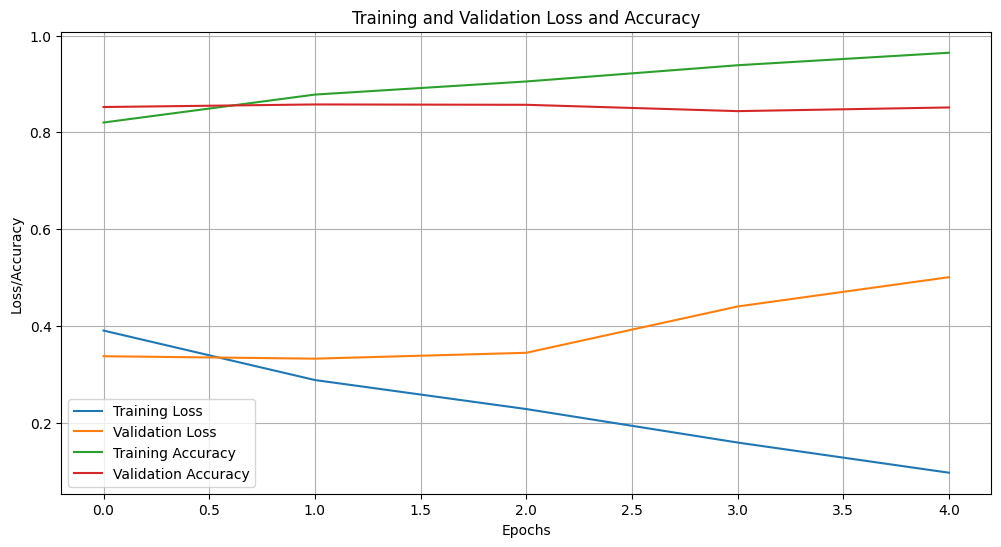

Validation Accuracy: 0.6464
Validation Accuracy: 0.6464


In [33]:
train_model(model, train_loader, valid_loader, epochs=5, lr=1e-3)
accuracy = get_accuracy(model, valid_loader)
print(f"Validation Accuracy: {accuracy:.4f}")

### Part (iii) [1pt MODEL]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Using device: cuda
Epoch 1: Train loss: 0.3861, Train Accuracy: 0.8240, Validation Loss: 0.3292, Validation Accuracy: 0.8583
Checkpoint saved at checkpoints/baseline/model_epoch_1.pth
Epoch 2: Train loss: 0.2764, Train Accuracy: 0.8822, Validation Loss: 0.3289, Validation Accuracy: 0.8574
Checkpoint saved at checkpoints/baseline/model_epoch_2.pth
Epoch 3: Train loss: 0.1913, Train Accuracy: 0.9242, Validation Loss: 0.3578, Validation Accuracy: 0.8548
Checkpoint saved at checkpoints/baseline/model_epoch_3.pth
Epoch 4: Train loss: 0.0969, Train Accuracy: 0.9665, Validation Loss: 0.4596, Validation Accuracy: 0.8530
Epoch 5: Train loss: 0.0450, Train Accuracy: 0.9846, Validation Loss: 0.5824, Validation Accuracy: 0.8469
Checkpoint saved at checkpoints/baseline/model_epoch_5.pth


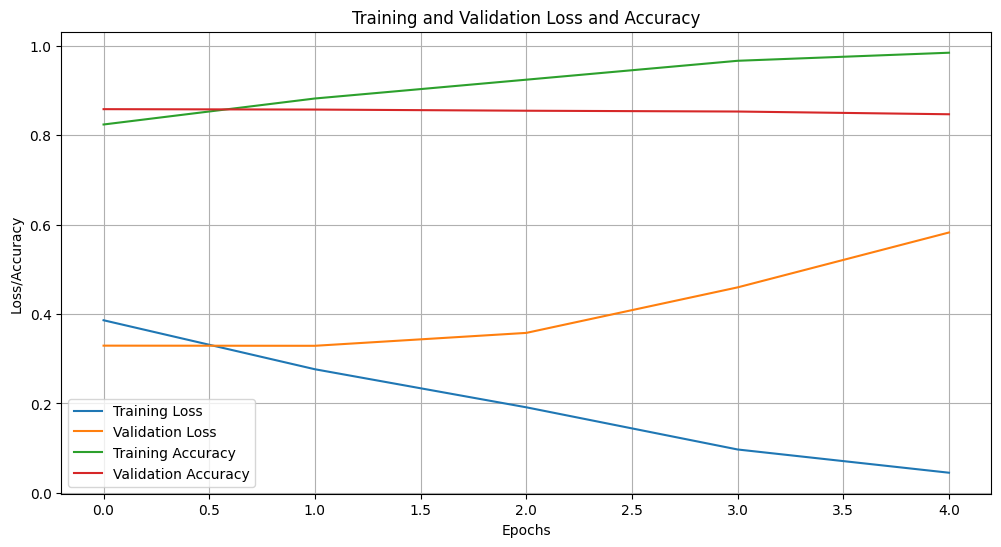

Validation Accuracy: 0.5689


([0.3860659759958585,
  0.2764383779287338,
  0.19131162458211184,
  0.09693068180121481,
  0.04495438434300013],
 [0.32924173514842986,
  0.3289241298675537,
  0.35776412842273714,
  0.45961694754958154,
  0.5824104676548392],
 [0.824,
  0.8821666666666667,
  0.9242333333333334,
  0.9665333333333334,
  0.9845666666666667],
 [0.8583, 0.8574, 0.8548, 0.853, 0.8469])

In [34]:
#Creating a baseline number using arbitary set hyperparameters
baseline_model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout=0)  #! value taken from above cells but setting dropout to zero since I dont think we are overfitting here yet
baseline_model.to(device)
train_model(baseline_model, train_loader, valid_loader, epochs=5, lr=1e-3,trainingName='baseline')


Using device: cuda
Epoch 1: Train loss: 0.3824, Train Accuracy: 0.8262, Validation Loss: 0.3270, Validation Accuracy: 0.8569
Epoch 2: Train loss: 0.2781, Train Accuracy: 0.8838, Validation Loss: 0.3272, Validation Accuracy: 0.8575
Epoch 3: Train loss: 0.2013, Train Accuracy: 0.9221, Validation Loss: 0.3549, Validation Accuracy: 0.8582
Checkpoint saved at checkpoints/increaedEpochs/model_epoch_3.pth
Epoch 4: Train loss: 0.1107, Train Accuracy: 0.9604, Validation Loss: 0.4444, Validation Accuracy: 0.8546
Epoch 5: Train loss: 0.0526, Train Accuracy: 0.9824, Validation Loss: 0.5479, Validation Accuracy: 0.8487
Epoch 6: Train loss: 0.0332, Train Accuracy: 0.9888, Validation Loss: 0.6012, Validation Accuracy: 0.8531
Epoch 7: Train loss: 0.0278, Train Accuracy: 0.9899, Validation Loss: 0.6973, Validation Accuracy: 0.8549
Checkpoint saved at checkpoints/increaedEpochs/model_epoch_7.pth
Epoch 8: Train loss: 0.0240, Train Accuracy: 0.9916, Validation Loss: 0.6996, Validation Accuracy: 0.8503
Epo

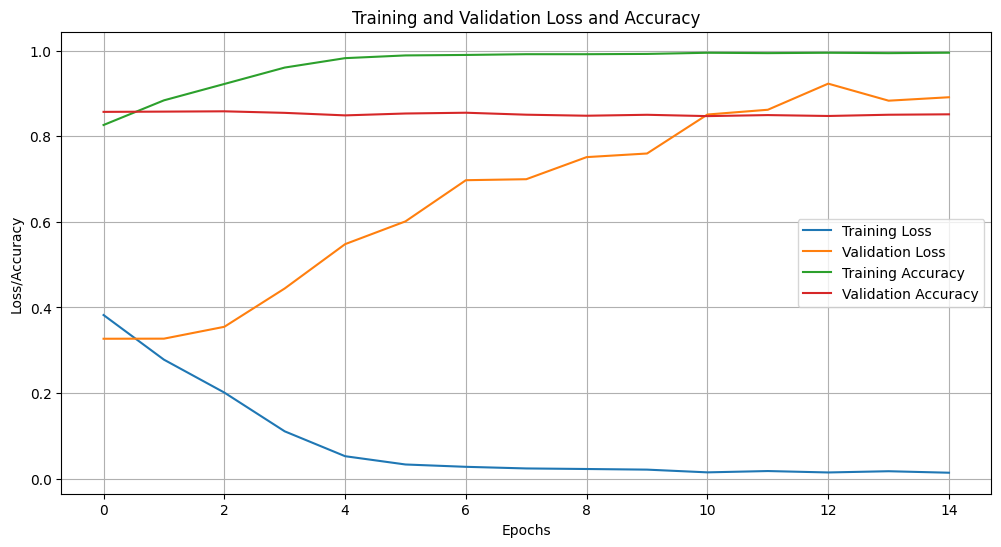

Validation Accuracy: 0.3259
Using device: cuda
Epoch 1: Train loss: 0.3859, Train Accuracy: 0.8239, Validation Loss: 0.3393, Validation Accuracy: 0.8507
Epoch 2: Train loss: 0.2793, Train Accuracy: 0.8804, Validation Loss: 0.3201, Validation Accuracy: 0.8591
Epoch 3: Train loss: 0.1972, Train Accuracy: 0.9251, Validation Loss: 0.3466, Validation Accuracy: 0.8560
Epoch 4: Train loss: 0.1033, Train Accuracy: 0.9634, Validation Loss: 0.4306, Validation Accuracy: 0.8555
Epoch 5: Train loss: 0.0470, Train Accuracy: 0.9839, Validation Loss: 0.5606, Validation Accuracy: 0.8498
Checkpoint saved at checkpoints/decreasedEpochs/model_epoch_5.pth
Epoch 6: Train loss: 0.0316, Train Accuracy: 0.9895, Validation Loss: 0.6854, Validation Accuracy: 0.8447
Epoch 7: Train loss: 0.0292, Train Accuracy: 0.9899, Validation Loss: 0.6862, Validation Accuracy: 0.8485
Epoch 8: Train loss: 0.0215, Train Accuracy: 0.9923, Validation Loss: 0.7509, Validation Accuracy: 0.8498
Epoch 9: Train loss: 0.0203, Train Accu

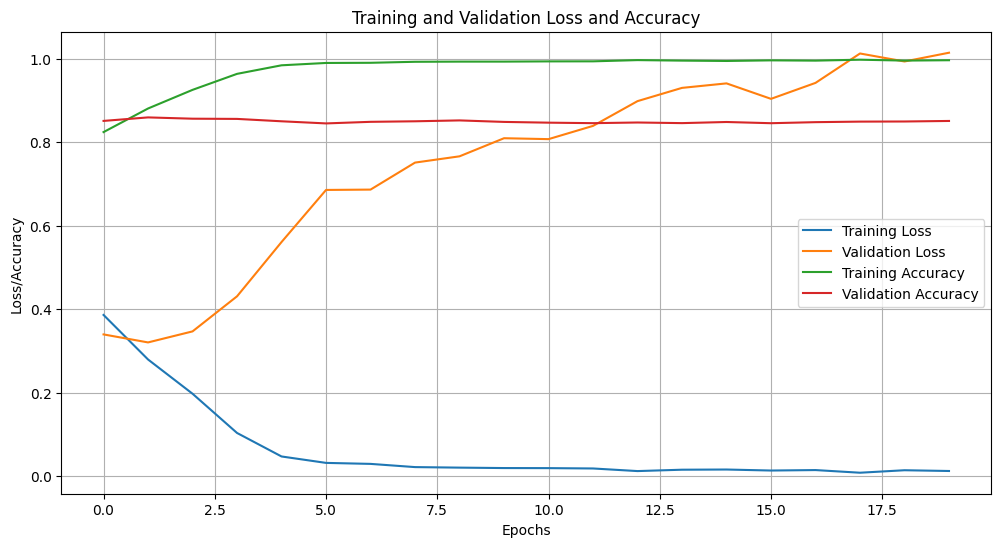

Validation Accuracy: 0.2961


([0.38593775974114736,
  0.27926460534731545,
  0.19723564754178127,
  0.10326970451536278,
  0.04698209973699413,
  0.03159345973930321,
  0.029216762235512336,
  0.021524097320683357,
  0.02026016297598738,
  0.019233883775462042,
  0.019057538354374872,
  0.01823838141630455,
  0.01199147961155771,
  0.015272539479645518,
  0.015727860437130342,
  0.013300432427956244,
  0.014406687893653482,
  0.008059702862861376,
  0.014008724601459084,
  0.012201562639898732],
 [0.3393133989095688,
  0.32014323409199713,
  0.3465779418647289,
  0.4305998223975301,
  0.5606051404420287,
  0.6853547005157917,
  0.6861896622102708,
  0.7508666700845584,
  0.765885547031276,
  0.8092291800523177,
  0.8070535744902445,
  0.8387831009169692,
  0.8980865016413329,
  0.9298159969236701,
  0.9405913185766898,
  0.9035402515396942,
  0.9417623498024186,
  1.01217829622383,
  0.9930454338093172,
  1.014021299939012],
 [0.8239333333333333,
  0.8804333333333333,
  0.9250666666666667,
  0.9634,
  0.9839,
  0.

In [35]:
vocab_size = 10000
embedding_dim = 300
hidden_dim = 128
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0
# Instantiate the model
increasedEpochs = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
increasedEpochs.to(device)
train_model(increasedEpochs, train_loader, valid_loader, epochs=15, lr=1e-3,trainingName='increaedEpochs')
decreasedEpochs = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
decreasedEpochs.to(device)
train_model(decreasedEpochs, train_loader, valid_loader, epochs=20, lr=1e-3,trainingName='decreasedEpochs')


Using device: cuda
Epoch 1: Train loss: 0.3862, Train Accuracy: 0.8249, Validation Loss: 0.3433, Validation Accuracy: 0.8478
Epoch 2: Train loss: 0.2768, Train Accuracy: 0.8845, Validation Loss: 0.3199, Validation Accuracy: 0.8635
Epoch 3: Train loss: 0.1794, Train Accuracy: 0.9292, Validation Loss: 0.3610, Validation Accuracy: 0.8570
Checkpoint saved at checkpoints/increasedHiddenDim/model_epoch_3.pth
Epoch 4: Train loss: 0.0705, Train Accuracy: 0.9755, Validation Loss: 0.5116, Validation Accuracy: 0.8508
Epoch 5: Train loss: 0.0286, Train Accuracy: 0.9910, Validation Loss: 0.7086, Validation Accuracy: 0.8437
Epoch 6: Train loss: 0.0261, Train Accuracy: 0.9905, Validation Loss: 0.7074, Validation Accuracy: 0.8482
Epoch 7: Train loss: 0.0209, Train Accuracy: 0.9928, Validation Loss: 0.7924, Validation Accuracy: 0.8537
Checkpoint saved at checkpoints/increasedHiddenDim/model_epoch_7.pth
Epoch 8: Train loss: 0.0234, Train Accuracy: 0.9916, Validation Loss: 0.8207, Validation Accuracy: 0.

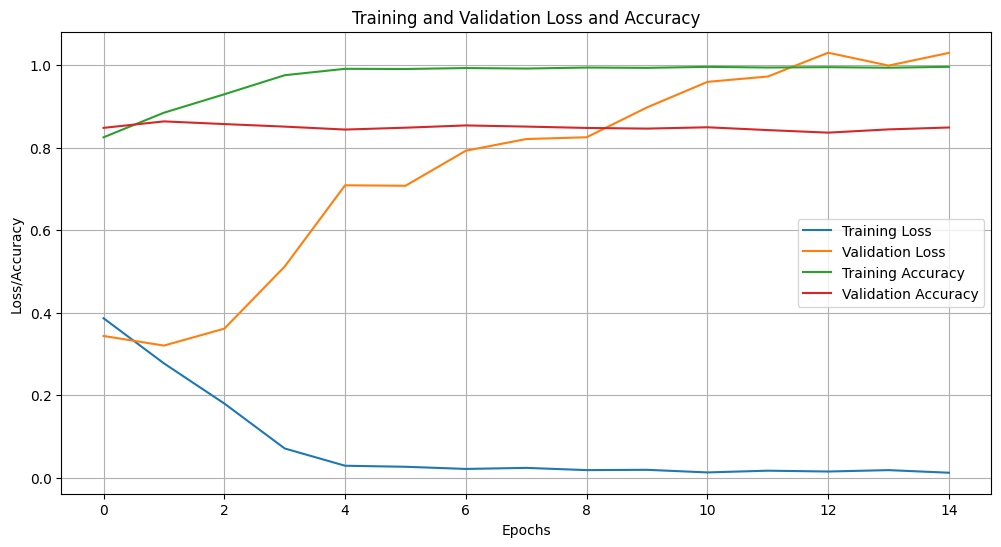

Validation Accuracy: 0.8487
Using device: cuda
Epoch 1: Train loss: 0.3883, Train Accuracy: 0.8216, Validation Loss: 0.3333, Validation Accuracy: 0.8535
Epoch 2: Train loss: 0.2783, Train Accuracy: 0.8845, Validation Loss: 0.3182, Validation Accuracy: 0.8639
Epoch 3: Train loss: 0.2099, Train Accuracy: 0.9167, Validation Loss: 0.3463, Validation Accuracy: 0.8550
Checkpoint saved at checkpoints/decreasedHiddenDim/model_epoch_3.pth
Epoch 4: Train loss: 0.1389, Train Accuracy: 0.9485, Validation Loss: 0.3864, Validation Accuracy: 0.8527
Epoch 5: Train loss: 0.0793, Train Accuracy: 0.9723, Validation Loss: 0.4772, Validation Accuracy: 0.8489
Epoch 6: Train loss: 0.0496, Train Accuracy: 0.9841, Validation Loss: 0.5531, Validation Accuracy: 0.8482
Epoch 7: Train loss: 0.0404, Train Accuracy: 0.9868, Validation Loss: 0.6447, Validation Accuracy: 0.8456
Checkpoint saved at checkpoints/decreasedHiddenDim/model_epoch_7.pth
Epoch 8: Train loss: 0.0286, Train Accuracy: 0.9906, Validation Loss: 0.6

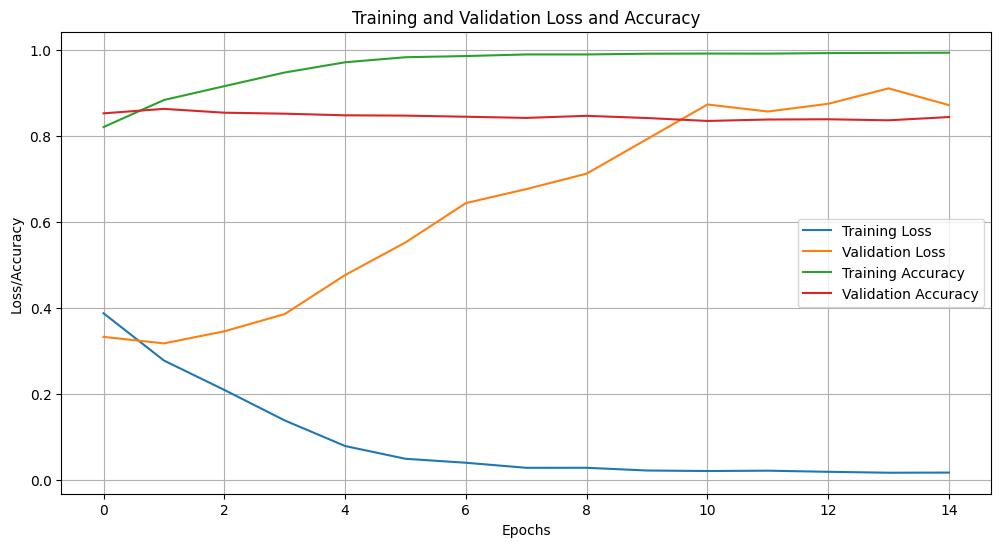

Validation Accuracy: 0.8449


([0.3882590227266153,
  0.27830408012866975,
  0.20985074695845446,
  0.13887085506344835,
  0.07932349010606607,
  0.04962641188831185,
  0.040400716758100315,
  0.02863002477991783,
  0.028658846219774083,
  0.022349326832092873,
  0.02112983735577679,
  0.021947933202050626,
  0.019337995422121217,
  0.017192942362330602,
  0.01751688079751639],
 [0.333293937587738,
  0.31817832199931145,
  0.3462532324999571,
  0.3864072018504143,
  0.477194115845114,
  0.5530822727203369,
  0.6446708151146769,
  0.6771753879114986,
  0.7132213684438262,
  0.7936018134109676,
  0.8740925432997058,
  0.8577131317526102,
  0.87571332094057,
  0.9116443238854641,
  0.8725567100648274],
 [0.8216,
  0.8845333333333333,
  0.9167333333333333,
  0.9485333333333333,
  0.9723333333333334,
  0.9840666666666666,
  0.9868333333333333,
  0.9905666666666667,
  0.9905666666666667,
  0.9922333333333333,
  0.9926333333333334,
  0.9925,
  0.9937,
  0.9942,
  0.9945666666666667],
 [0.8535,
  0.8639,
  0.855,
  0.8527,

In [69]:
vocab_size = 10000
embedding_dim = 300
hidden_dim = 128*2 #! increased hidden dim
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0
# Instantiate the model
increasedHiddenDim = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
increasedHiddenDim.to(device)
train_model(increasedHiddenDim, train_loader, valid_loader, epochs=15, lr=1e-3,trainingName='increasedHiddenDim')
hidden_dim = 64 #! decreased hidden dim
decreasedHiddenDim = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
decreasedHiddenDim.to(device)
train_model(decreasedHiddenDim, train_loader, valid_loader, epochs=15, lr=1e-3,trainingName='decreasedHiddenDim')

Using device: cuda
Epoch 1: Train loss: 0.3929, Train Accuracy: 0.8198, Validation Loss: 0.3915, Validation Accuracy: 0.8289
Epoch 2: Train loss: 0.3525, Train Accuracy: 0.8462, Validation Loss: 0.3737, Validation Accuracy: 0.8364
Epoch 3: Train loss: 0.3545, Train Accuracy: 0.8449, Validation Loss: 0.4145, Validation Accuracy: 0.8190
Checkpoint saved at checkpoints/increasedLR/model_epoch_3.pth
Epoch 4: Train loss: 0.3488, Train Accuracy: 0.8454, Validation Loss: 0.3722, Validation Accuracy: 0.8373
Epoch 5: Train loss: 0.3499, Train Accuracy: 0.8465, Validation Loss: 0.3689, Validation Accuracy: 0.8341
Epoch 6: Train loss: 0.3479, Train Accuracy: 0.8460, Validation Loss: 0.4025, Validation Accuracy: 0.8238
Epoch 7: Train loss: 0.3474, Train Accuracy: 0.8482, Validation Loss: 0.4013, Validation Accuracy: 0.8176
Checkpoint saved at checkpoints/increasedLR/model_epoch_7.pth
Epoch 8: Train loss: 0.3478, Train Accuracy: 0.8463, Validation Loss: 0.3971, Validation Accuracy: 0.8208
Epoch 9: 

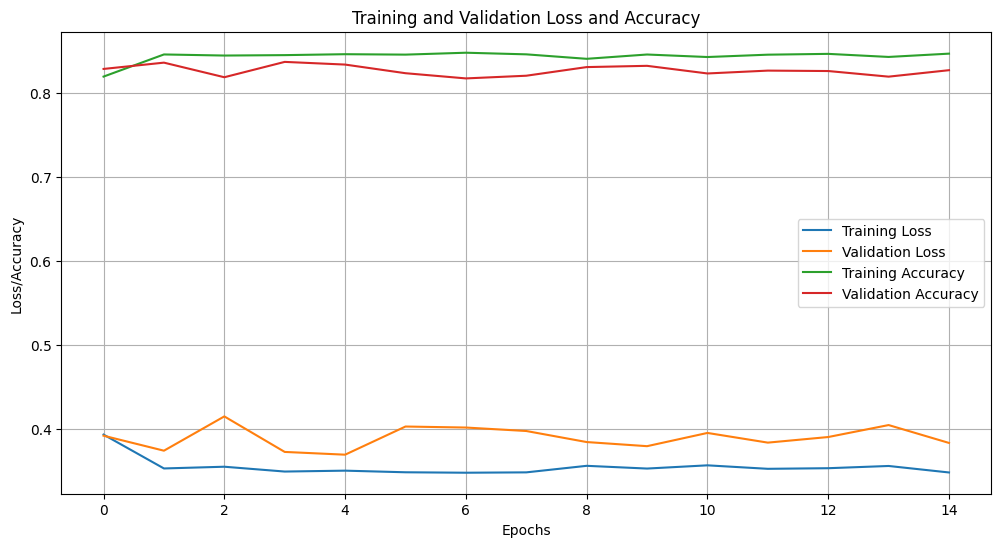

Validation Accuracy: 1.8621
Using device: cuda
Epoch 1: Train loss: 0.4791, Train Accuracy: 0.7629, Validation Loss: 0.3772, Validation Accuracy: 0.8334
Epoch 2: Train loss: 0.3377, Train Accuracy: 0.8546, Validation Loss: 0.3508, Validation Accuracy: 0.8466
Epoch 3: Train loss: 0.3008, Train Accuracy: 0.8735, Validation Loss: 0.3448, Validation Accuracy: 0.8526
Checkpoint saved at checkpoints/decreasedLR/model_epoch_3.pth
Epoch 4: Train loss: 0.2683, Train Accuracy: 0.8887, Validation Loss: 0.3500, Validation Accuracy: 0.8513
Epoch 5: Train loss: 0.2419, Train Accuracy: 0.9020, Validation Loss: 0.3618, Validation Accuracy: 0.8480
Epoch 6: Train loss: 0.2146, Train Accuracy: 0.9155, Validation Loss: 0.3554, Validation Accuracy: 0.8536
Epoch 7: Train loss: 0.1846, Train Accuracy: 0.9299, Validation Loss: 0.3861, Validation Accuracy: 0.8536
Checkpoint saved at checkpoints/decreasedLR/model_epoch_7.pth
Epoch 8: Train loss: 0.1577, Train Accuracy: 0.9414, Validation Loss: 0.4142, Validatio

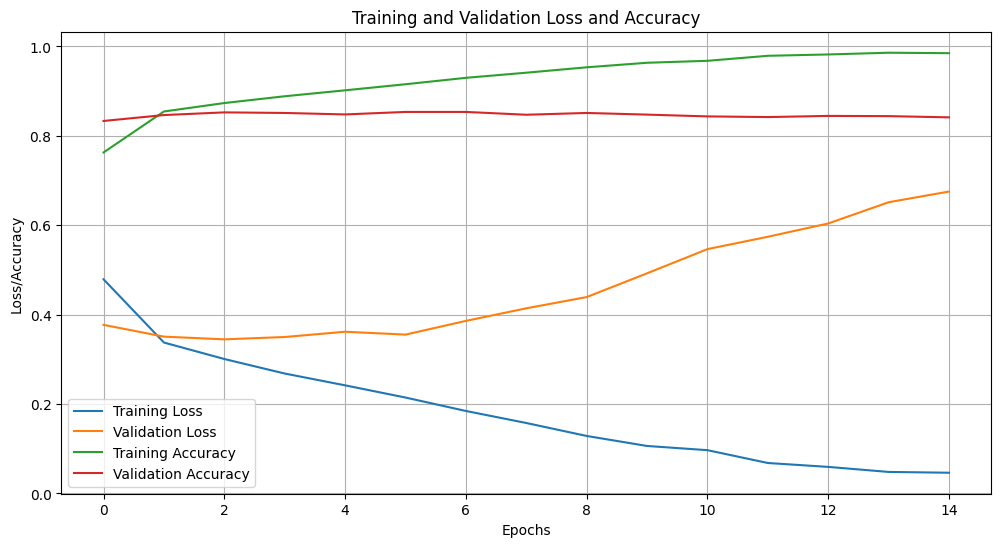

Validation Accuracy: 0.4889


([0.47913789482514063,
  0.33766905198891956,
  0.30079025456309316,
  0.2683179057379564,
  0.24189558265010516,
  0.21460953027158974,
  0.18455926148394744,
  0.15765522334525983,
  0.12864542674372595,
  0.10624710155203938,
  0.09684683363984029,
  0.06815080597689376,
  0.059416889802319926,
  0.04815251512217025,
  0.046389090729729895],
 [0.37721107225418093,
  0.35084598346948626,
  0.34480360976457597,
  0.3500131253540516,
  0.3618069662332535,
  0.3554217991262674,
  0.38605526578128335,
  0.41422086302787064,
  0.4393718859091401,
  0.49251136670783163,
  0.5466548069156706,
  0.5742802160121501,
  0.604044451213628,
  0.6515234722146764,
  0.6754692588951439],
 [0.7629333333333334,
  0.8546,
  0.8734666666666666,
  0.8886666666666667,
  0.9019666666666667,
  0.9155333333333333,
  0.9299,
  0.9413666666666667,
  0.9534333333333334,
  0.9636,
  0.9679666666666666,
  0.9792,
  0.9822,
  0.9860666666666666,
  0.9850666666666666],
 [0.8334,
  0.8466,
  0.8526,
  0.8513,
  0.84

In [38]:
vocab_size = 10000
embedding_dim = 300
hidden_dim = 128
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0
# Instantiate the model
increasedLR = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
increasedLR.to(device)
train_model(increasedLR, train_loader, valid_loader, epochs=15, lr=1e-2,trainingName='increasedLR')
decreasedLR = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
decreasedLR.to(device)
train_model(decreasedLR, train_loader, valid_loader, epochs=15, lr=1e-4,trainingName='decreasedLR')

Using device: cuda
Epoch 1: Train loss: 0.3867, Train Accuracy: 0.8206, Validation Loss: 0.3280, Validation Accuracy: 0.8595
Epoch 2: Train loss: 0.2770, Train Accuracy: 0.8854, Validation Loss: 0.3254, Validation Accuracy: 0.8581
Epoch 3: Train loss: 0.1936, Train Accuracy: 0.9237, Validation Loss: 0.3628, Validation Accuracy: 0.8545
Checkpoint saved at checkpoints/increasedBS32/model_epoch_3.pth
Epoch 4: Train loss: 0.0991, Train Accuracy: 0.9655, Validation Loss: 0.4478, Validation Accuracy: 0.8533
Epoch 5: Train loss: 0.0438, Train Accuracy: 0.9858, Validation Loss: 0.5492, Validation Accuracy: 0.8470
Epoch 6: Train loss: 0.0312, Train Accuracy: 0.9893, Validation Loss: 0.6963, Validation Accuracy: 0.8438
Epoch 7: Train loss: 0.0270, Train Accuracy: 0.9904, Validation Loss: 0.7331, Validation Accuracy: 0.8510
Checkpoint saved at checkpoints/increasedBS32/model_epoch_7.pth
Epoch 8: Train loss: 0.0275, Train Accuracy: 0.9898, Validation Loss: 0.7040, Validation Accuracy: 0.8474
Epoch

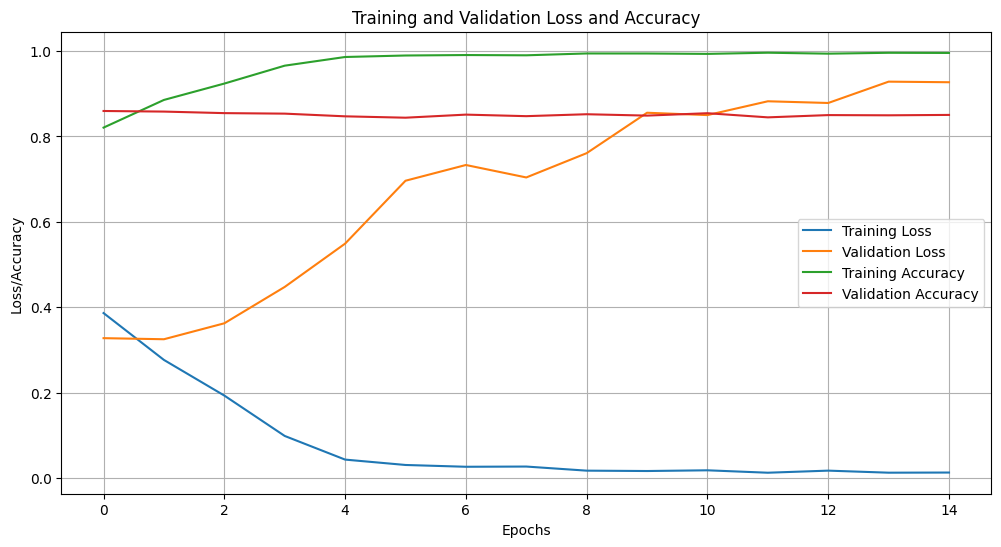

Validation Accuracy: 0.3432
Using device: cuda
Epoch 1: Train loss: 0.3839, Train Accuracy: 0.8227, Validation Loss: 0.3313, Validation Accuracy: 0.8542
Epoch 2: Train loss: 0.2804, Train Accuracy: 0.8845, Validation Loss: 0.3192, Validation Accuracy: 0.8611
Epoch 3: Train loss: 0.2021, Train Accuracy: 0.9204, Validation Loss: 0.3860, Validation Accuracy: 0.8527
Checkpoint saved at checkpoints/increasedBS64/model_epoch_3.pth
Epoch 4: Train loss: 0.1100, Train Accuracy: 0.9607, Validation Loss: 0.4106, Validation Accuracy: 0.8527
Epoch 5: Train loss: 0.0530, Train Accuracy: 0.9835, Validation Loss: 0.5452, Validation Accuracy: 0.8517
Epoch 6: Train loss: 0.0303, Train Accuracy: 0.9895, Validation Loss: 0.6822, Validation Accuracy: 0.8473
Epoch 7: Train loss: 0.0293, Train Accuracy: 0.9900, Validation Loss: 0.6611, Validation Accuracy: 0.8471
Checkpoint saved at checkpoints/increasedBS64/model_epoch_7.pth
Epoch 8: Train loss: 0.0251, Train Accuracy: 0.9913, Validation Loss: 0.7027, Valid

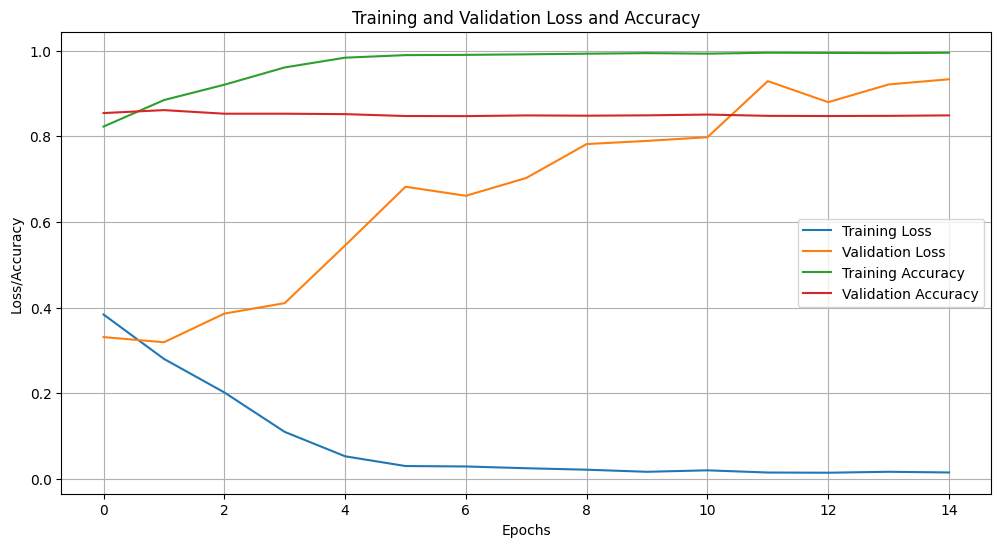

Validation Accuracy: 0.3248


([0.3839447342256705,
  0.28039410668412845,
  0.20212730365196863,
  0.10995008355341852,
  0.05301772407688356,
  0.030260571641211088,
  0.029261922250502052,
  0.02512744905423315,
  0.021700600628968097,
  0.016822249767277874,
  0.02024540054006902,
  0.015116029875266153,
  0.014659491236344396,
  0.016868560851995243,
  0.015226361385407047],
 [0.3312778753399849,
  0.31921296617984773,
  0.386041547486186,
  0.4105517778918147,
  0.5452094506885856,
  0.6822340164202265,
  0.661114662810415,
  0.7027106540393084,
  0.7818600599290803,
  0.7892722658060491,
  0.7978132719109766,
  0.9287608882450499,
  0.8796420875835698,
  0.9209834422399057,
  0.9331308472866192],
 [0.8227,
  0.8845333333333333,
  0.9203666666666667,
  0.9607333333333333,
  0.9835,
  0.9894666666666667,
  0.9900333333333333,
  0.9913,
  0.9928,
  0.9941333333333333,
  0.9928666666666667,
  0.9950666666666667,
  0.9946333333333334,
  0.9941666666666666,
  0.995],
 [0.8542,
  0.8611,
  0.8527,
  0.8527,
  0.851

In [39]:
vocab_size = 10000
embedding_dim = 300
hidden_dim = 128
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0
# Instantiate the model
increasedBS = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
increasedBS.to(device)
train_model(increasedBS, train_loader, valid_loader, epochs=15, lr=1e-3,batch_size=32,trainingName='increasedBS32')
increasedBS64 = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
increasedBS64.to(device)
train_model(increasedBS64, train_loader, valid_loader, epochs=15, lr=1e-3,batch_size=64,trainingName='increasedBS64')

In [ ]:
'''
Batch Size:
Tuning Approach: I experimented with various batch sizes such as 16, 32, 64, and 128 to observe how they affect the training speed and model performance.
Rationale: Smaller batch sizes can improve generalization but slow down training, while larger batch sizes accelerate training but may lead to poorer generalization. I aimed to find a balance where the model trains efficiently without compromising its ability to generalize well.

Hidden Dimension (hidden_dim):
Tuning Approach: For models like LSTMs or fully connected layers in neural networks, I tested different sizes of hidden layers, such as 128, 256, 512, to see how they impact the model's learning capacity.
Rationale: A larger hidden dimension can capture more complex patterns but may also lead to overfitting. In contrast, a smaller hidden dimension may not capture the data complexity well. The goal was to find a hidden dimension size that provides sufficient capacity to learn the data patterns without overfitting.

Learning Rate:
Tuning Approach: I experimented with learning rates across different magnitudes, starting from 0.1, 0.01, 0.001, to 0.0001, to find the rate at which the model learns best.
Rationale: The learning rate is crucial for how quickly a model converges to a minimum loss value. Too high can cause overshooting, while too low can lead to slow convergence. Finding an optimal learning rate is key to efficient training and convergence.

Epochs:
Tuning Approach: I adjusted the number of epochs, starting with a smaller number like 10 and increasing to 20, 50, or more based on the model’s performance and training time.
Rationale: More epochs can lead to better learning up to a point, but beyond that, it might just cause overfitting and waste computational resources. The idea was to find an optimal number of epochs where the model has learned sufficiently without overfitting.


'''

## Part 4. Evaluation [10 pt]

**Important**. At this point in the assignment your test data should not have been evaluated by any of your models. The test data should be evaluated only after you have finished all the previous parts of the assignment. Once you evaluate your models on the test data you cannot change your models or else you may make hyperparameter adjustments that could lead to overfitting to the test data.

### Part (i) [3pt RESULT]

Report the final test accuracy of your model. Comment on how the result compares with accuracy obtained on the training and validation data. Are the results what you expected? Explain.

Using device: cuda
Epoch 1: Train loss: 0.3956, Train Accuracy: 0.8157, Validation Loss: 0.3395, Validation Accuracy: 0.8497
Checkpoint saved at checkpoints/finalModel/model_epoch_1.pth
Epoch 2: Train loss: 0.2860, Train Accuracy: 0.8812, Validation Loss: 0.3192, Validation Accuracy: 0.8621
Checkpoint saved at checkpoints/finalModel/model_epoch_2.pth
Epoch 3: Train loss: 0.2123, Train Accuracy: 0.9160, Validation Loss: 0.3904, Validation Accuracy: 0.8430
Checkpoint saved at checkpoints/finalModel/model_epoch_3.pth
Epoch 4: Train loss: 0.1244, Train Accuracy: 0.9558, Validation Loss: 0.4181, Validation Accuracy: 0.8546
Epoch 5: Train loss: 0.0562, Train Accuracy: 0.9811, Validation Loss: 0.5959, Validation Accuracy: 0.8442
Checkpoint saved at checkpoints/finalModel/model_epoch_5.pth


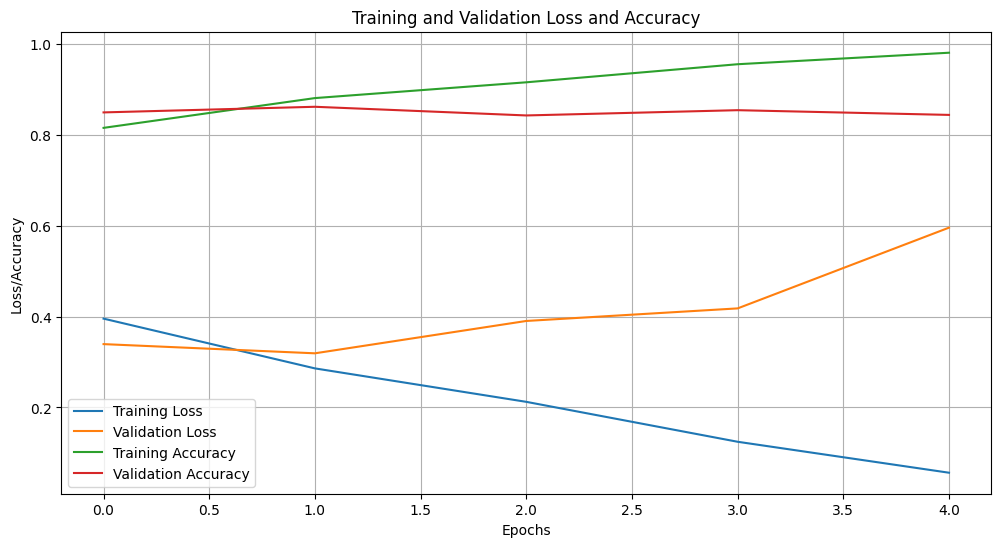

Validation Accuracy: 0.5796


([0.3955833072741826,
  0.2860027535359065,
  0.21234138483802478,
  0.12441243627220393,
  0.05624679205003195],
 [0.3394528988242149,
  0.319200968337059,
  0.3904390021979809,
  0.418118007285893,
  0.5959127356275916],
 [0.8156666666666667, 0.8812333333333333, 0.916, 0.9558, 0.9811333333333333],
 [0.8497, 0.8621, 0.843, 0.8546, 0.8442])

In [41]:
#! im first going to make a model based on what i learned from tuning 
vocab_size = 10000
embedding_dim = 300
hidden_dim = 64
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0
# Instantiate the model
finalModel = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
finalModel.to(device)
train_model(finalModel, train_loader, valid_loader, epochs=5, lr=1e-3,batch_size=64,trainingName='finalModel')

In [47]:
# TO BE COMPLETED
finalModel = finalModel.cuda()
checkpoint = torch.load("checkpoints/finalModel/model_epoch_5.pth")
finalModel.load_state_dict(checkpoint['model_state_dict'])

test_loader = DataLoader(dataset=test, batch_size=64)
accuracy = get_accuracy(finalModel, test_loader)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8477


In [135]:
'''
The final test acuracy is 84.77% which is slightly under the training accuracy (98%) and the validation accruacy of (85). This behaviour is expected because it is generlizing to unseen cases
however to further improve it, it will be benficial to further increase epochs to see if there is better convergence point. To pick this model I compared the increased and decreased values from each fine-tuning run
I had to make estimated guesses because of limite computing power. 

'''


'\nThe final test acuracy is 84.77% which is slightly under the training accuracy (98%) and the validation accruacy of (85). This behaviour is expected because it is generlizing to unseen cases\nhowever to further improve it, it will be benficial to further increase epochs to see if there is better convergence point. To pick this model I compared the increased and decreased values from each fine-tuning run\nI had to make estimated guesses because of limite computing power. \n\n'

### Part (ii) [3pt DISCUSSION]

Look over the misclassified samples in the test data and see if you can find any patterns on where the model has difficulty with identifying the review sentiment. Provide up to 5 examples of positive and negative reviews each to support your findings.

In [63]:
def evaluate_model_predictions(model, data_loader, stoi):
    for data, labels in data_loader:
        data, labels = data.cuda(), labels.cuda().float()
        outputs = model(data)

        incorrect_predictions = (outputs > 0.0).squeeze().long() != labels.long()
        incorrect_data = data[incorrect_predictions == True]
        incorrect_labels = labels[incorrect_predictions == True]

        stoi_switch = {value: key for key, value in stoi.items()}
        for i in range(incorrect_data.shape[0]):
            sentence_tokens = incorrect_data[i, :]
            output_sentence = " ".join([stoi_switch[int(val)] for val in sentence_tokens if int(val) != 0])

            print("Number:", i)
            print("Sentence:", output_sentence)
            print("Predicted:", "positive" if int(incorrect_labels[i]) == 1 else "negative")
            print("Truth:", "positive" if int(incorrect_labels[i]) == 0 else "negative")
            print("---")

        break  


evaluate_model_predictions(model=finalModel, data_loader=test_loader, stoi=seqToInt)


Number: 0
Sentence: james political get become boys school wants make lives kids comes background like br villain piece one plot hell kids mostly power note mess scene well kids getting quality wouldnt br back city take back setting film br hell typical working class gets pretty times later version crime school dead end kids br although fine lead role school acting go hard believe man could one fine watch every film hes br br film shown often whole lot would today still fine filmbr br enough years ago film came guess films dont change time
Predicted: positive
Truth: negative
---
Number: 1
Sentence: movie full horror movie murder mad female even father horrible male female mind car lot incredibly awful score worst work ever br script even badly horror movie editing bizarre one scene lead female evil goes one badly understand scenes movie hand girls gets reason cover cut bad though went dont know plenty place even br director one star film looks like mess made even footage different film

In [ ]:
'''
Just from reading some of the cases, I think it is what I predicted in an earlier question where the model is almost counting number of postiive and negative words not fully but it is making an impact. so if there are not 
many positive words or negative words respectively, that example is getting misclassified. Also worth noting in the case of negative reviews sentences which require more semantic knowlege to differentie thriller from movie type or emotion 
it is failing in. or if the statement sounds contradicting which is a way people talk. 

'''


### Part (iii) [2pt RESULT]

What is your model's prediction of the **probability** that
the review message provided below is a positive review?

Hint: You will need to apply the same processing on the review as was done on the the train, val, and test data sets.

In [66]:
review = """ Man.... I wish I loved this movie more than I did. Don't get me wrong,
it's a solid action movie with jaw-dropping stunts (some of the best in the series),
but as a Mission: Impossible movie, it felt like a small step backward for the franchise.
Fallout had mind-blowing action sequences and stunt work, along with developing Ethan's
relationship with Ilsa, providing closure with Julia, showing the lengths Ethan would
go to protect those closest to him, and battling an imposing villain. Dead Reckoning:
Part One stretches the movie across two films only to seemingly showcase action
spectacle after action spectacle while sacrificing character development.
Characters I have grown to love over a decade of films felt sidelined, ignored,
or wasted. Hayley Atwell's new character chewed up most of the screen time, and
while she was fantastic, I wanted to see more of the original team. The new villain
had an inconsistent ability that confused more than intimidated. There were some
important emotional moments that I just didn't feel the weight of when I definitely
should have. Part Two might tie everything together and make me enjoy Part One
more in retrospect, but unfortunately, I left wanting more from this one.""" 



In [68]:
input, label = tokenize([str(review)], [0], seqToInt)
input = padding_(input, seq_len=500)
input, label = np.array(input), np.array(label)
print(input.shape, label.shape)
testingOne = TensorDataset(torch.tensor(input), torch.tensor(label))
newLoader = DataLoader(dataset=testingOne, batch_size=1)
for q,w in newLoader:
    # Generate predictions
    q, w = q.cuda(), w.cuda().float()
    output = finalModel(q)
    print("model prediction:",output,w)




(1, 500) (1,)
model prediction: tensor([[0.7403]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([0.], device='cuda:0')


<font color=red>the proabability is 74.03% of being positive

### Part (iv) [2pt DISCUSSION]

Do you think that detecting positive and negative reviews is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
'''

Detecting positive and negative reviews can range from being relatively straightforward to quite complex, depending on the semantics of the language, context, and sentiment expression in the reviews. 
 some reviews might explicitly express sentiment with words that are easy to classify, making them easier to classify, 
 others might use sarcasm, nuanced language, or context-dependent expressions that can be challenging for models to interpret accurately.




Preprocessing: Clean the text by removing special characters and converting to lowercase. Tokenize the text into words or phrases.

Feature Extraction: For rule-based analysis, create lists of positive and negative words. For machine learning, convert text to numerical data using methods like bag-of-words or TF-IDF.

Model Selection: Choose a simple model like logistic regression to basically classify based on word count of postive and negative sentiment words from the input. 
Training and Evaluation: Train on a dataset where you know how many negative and positive sentiment words are in there, to create this dataset you can use LLMs which have gotten very good at NLU.
The goal here is to basically count and measure the distubtuion of negative and positive words in an input using a very rudemantry method. 




'''

# PART B - Transfer Learning

For many natural language processing tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to enormous compute requirements and lack of sufficient amounts of training data. Instead, you should always try to take advantage of an existing model that performs similar tasks as the one you need to solve.

In this part of the assignment we will be using pretrained models to improve the performance on identifying positive and negative reviews. There are several pretrained models that are available to us, here we will use a pretrained BERT model that comes with the hugging face transformer library.

Provided below is sample code to get you started. For more details please visit the hugging face tutorial on using pretrained models using PyTorch: https://huggingface.co/docs/transformers/training

#### Sample Code

In [98]:
# install relevant libraries
!pip install -qq transformers

/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [99]:
# load relevant libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

################### SUBMISSION NOTE ####################################
#  - output of this cell creates issues for converting ipynb to HTML
#  - you may want to delete this output when you are ready to submit

In [100]:
sample_txt = 'I want to learn how to do sentiment analysis using BERT and tokenizer.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation = True
)

/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [101]:
encoding['input_ids']

tensor([[  101,   146,  1328,  1106,  3858,  1293,  1106,  1202, 17024,  3622,
          1606,   139,  9637,  1942,  1105, 22559, 17260,   119,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [102]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [103]:
hidden_states = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[0]
pooled_output = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[1]

In [105]:
hidden_size = bert_model.config.hidden_size
print(hidden_size)
print(hidden_states.shape)
print(pooled_output.shape)

768
torch.Size([1, 32, 768])
torch.Size([1, 768])


In the sample code provided we loaded a short text sequence, tokenized it using the same tokenization that was used in the pretrained BERT model, and fed the tokenized input into the BERT model to obtain the embeddings.

The model output consists of two forms of embeddings:
- **hidden_states** are the final layer of outputs that has a shape sequence_length x embeddings, much like the hidden states of a recurrent neural network
- **pooled_output** is the result of applying max pooling on the hidden states to effectively collapse the sequence dimenension and ensure the same output size for any given sequence before feeding into the classification stage

Note that you can preprocess all of the data prior to training a classifier stage for sentiment analysis to help speed up the training process. This is no different from the process we applied in an earlier assignment using AlexNet and image data.

## Part 1. Data Loading [5 pt]

We will be using the same "IMDB Movie Review Dataset" that we used earlier. Reload the data and complete Part B of the assignment. You should be able to complete part B independently from Part A.

### Part (i) [1pt EXPLORATORY]

Provided below is a DataLoader for your training and test datasets so you can iterate over batches of data. Run the DataLoader to create your training, validation, and test data.

In [106]:
from torch.utils.data import Dataset, DataLoader

class MovieReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    #obtain numerical labels
    target = 1 if self.targets[item] == 'positive' else 0

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [107]:
# prepare data loaders
MAX_LEN = 400
BATCH_SIZE = 16
# Get dataloaders
df= pd.read_csv("IMDB Dataset.csv")
df_train = df[:30000]
df_valid = df[30000:40000]
df_test = df[40000:50000]
#training data
train_data = MovieReviewDataset(reviews=df_train['review'].to_numpy(),
                                targets=df_train['sentiment'].to_numpy(),
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)

train_data_loader = DataLoader(train_data, batch_size = BATCH_SIZE, num_workers = 4) 

valid_data = MovieReviewDataset(reviews=df_valid['review'].to_numpy(),
                                targets=df_valid['sentiment'].to_numpy(),
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)

valid_data_loader = DataLoader(valid_data, batch_size = BATCH_SIZE, num_workers = 4)  

# Test data
test_data = MovieReviewDataset(reviews=df_test['review'].to_numpy(),
                               targets=df_test['sentiment'].to_numpy(),
                               tokenizer=tokenizer,
                               max_len=MAX_LEN)

test_data_loader = DataLoader(test_data, batch_size = BATCH_SIZE, num_workers = 4)  
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=4)
valid_data_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=4)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=4)



### Part (ii) [1pt EXPLORATORY]

Use the **train_data_loader** to load one sample. What are the different attributes provided with the sample and how are they used?

In [108]:
# Load one batch of data
sample_batch = next(iter(train_data_loader))
# Show the keys of the sample
print(sample_batch.keys())
print("Review text:", sample_batch['review_text'][0])  # first review text in the batch
print("Input IDs:", sample_batch['input_ids'][0])  # input_ids of the first sample
print("Attention Mask:", sample_batch['attention_mask'][0])  # attention mask of the first sample
print("Target:", sample_batch['targets'][0])  # target label of the first sample

/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
Review text: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are ne

In [ ]:
'''
review text will you give you the original movie review. we use this later to reference back as a ground truth

input ids give you the tokenized version of the sentence, this is our input to bert

attention masks is a tesnsor of 0 or 1 which will cover/mask if a word is padding or if its an actual word in our input/sentence.it is also a part of our input

labels are the classification of the review, meaning when we compare back to the review text, this is the respective is it a postive or negative review variable, therefore it is part of the ground truth, and will be used for loss calcs. 





'''

### Part (iii) [1pt EXPLORATORY]

Determine the range of values for the tokens in the training data. How are the tokens obtained?

Hint: You can apply your intuition here, or do some additional research to find how the "bert-base-cased" tokenization is done.

In [109]:
def calculate_token_range(data_loader):
    # Initialize a set to keep track of unique token ids
    unique_tokens = set()
    for batch in data_loader:
        # Extract input_ids from the batch
        input_ids = batch['input_ids']
        # Update the set of unique tokens with the new ids found in this batch
        unique_tokens.update(input_ids.view(-1).tolist())
    # Convert the set to a sorted list to get the range of token values
    sorted_tokens = sorted(unique_tokens)
    return sorted_tokens[0], sorted_tokens[-1]  # Return the first and last elements as the range
# Get the range of token values in the training data
token_min, token_max = calculate_token_range(train_data_loader)
print(f"The range of token values in the training data is from {token_min} to {token_max}")


/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

The range of token values in the training data is from 0 to 28223


In [ ]:
'''

the range is from 0-28223. BERT tokenization is done through splitting input sentences into residual parts, the tokens which are some grouping of charachters. there are also special 
tokens such as UNK or SEP which refer to unclear ot mark the end of sentences. this is to standarize the input to the model, each token is then converted to an id to be used by BERT. The id is stored in the pretrained bert vocabulary. 





'''

### Part (iv) [1pt EXPLORATORY]

Generate histograms of all the token values in the training data. Repeat for the validation and test data. What are the top 5 occuring tokens in the training_dataset? What do these tokens represent?

/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

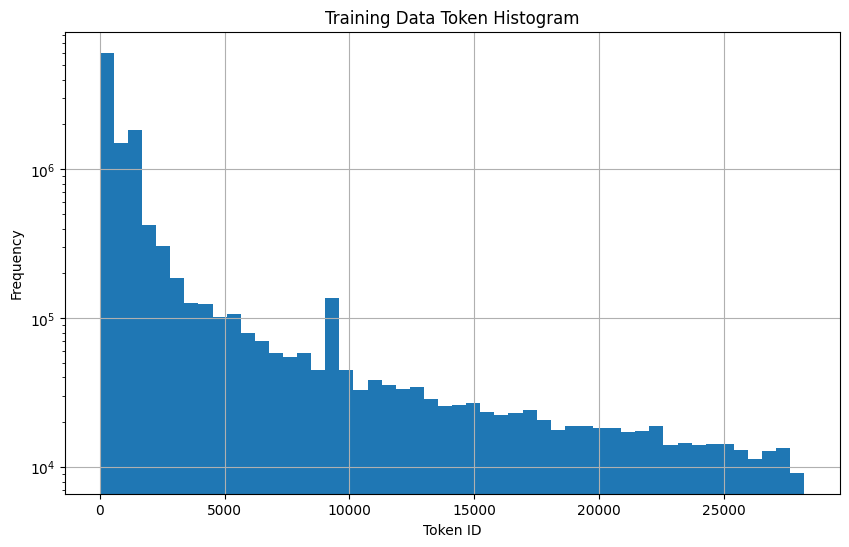

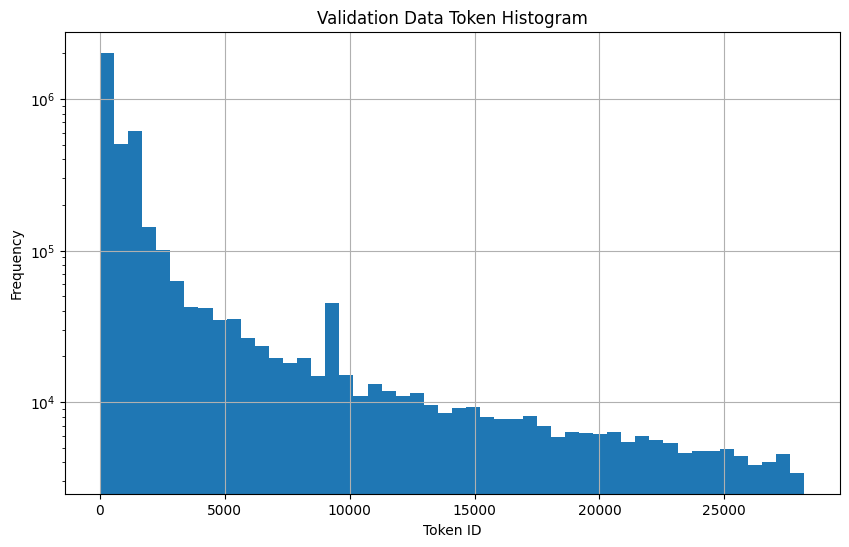

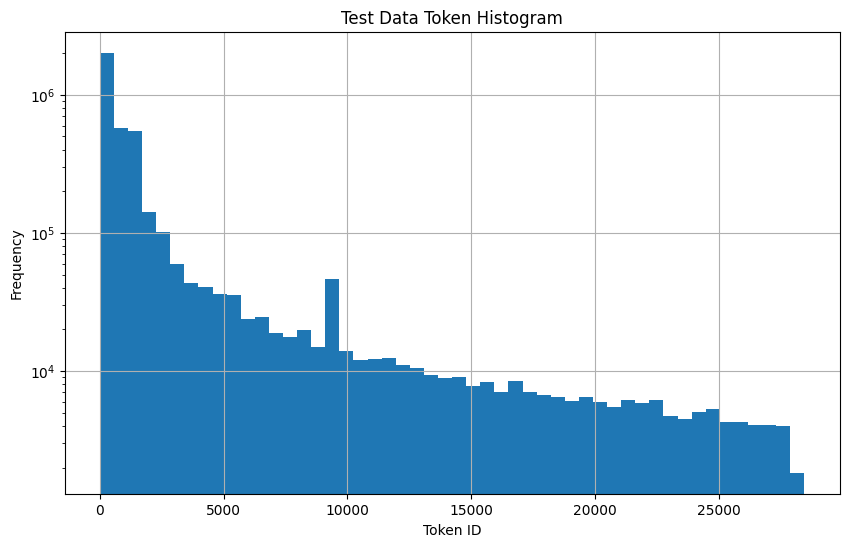

Top 5 occurring tokens in the training dataset:
Token ID 0 occurs 4293191 times
Token ID 119 occurs 317646 times
Token ID 1103 occurs 275924 times
Token ID 117 occurs 259234 times
Token ID 170 occurs 153504 times


In [110]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to get token counts from a dataset
def get_token_counts(data_loader):
    token_counts = Counter()
    for batch in data_loader:
        input_ids = batch['input_ids']
        token_counts.update(input_ids.flatten().tolist())
    return token_counts
# Get token counts for each dataset
train_token_counts = get_token_counts(train_data_loader)
valid_token_counts = get_token_counts(valid_data_loader)
test_token_counts = get_token_counts(test_data_loader)
# Function to plot the histogram
def plot_token_histogram(token_counts, title):
    plt.figure(figsize=(10, 6))
    plt.hist(token_counts.keys(), bins=50, weights=list(token_counts.values()), log=True)
    plt.title(title)
    plt.xlabel('Token ID')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
# Plot histograms
plot_token_histogram(train_token_counts, 'Training Data Token Histogram')
plot_token_histogram(valid_token_counts, 'Validation Data Token Histogram')
plot_token_histogram(test_token_counts, 'Test Data Token Histogram')
# Find the top 5 occurring tokens in the training dataset
top_tokens = train_token_counts.most_common(5)
print("Top 5 occurring tokens in the training dataset:")
for token_id, count in top_tokens:
    print(f"Token ID {token_id} occurs {count} times")




In [111]:
print("Top 5 tokens and their corresponding text:")
for token_id, _ in top_tokens:
    token = tokenizer.convert_ids_to_tokens(token_id)
    print(f"Token ID {token_id} represents '{token}'")

Top 5 tokens and their corresponding text:
Token ID 0 represents '[PAD]'
Token ID 119 represents '.'
Token ID 1103 represents 'the'
Token ID 117 represents ','
Token ID 170 represents 'a'


In [ ]:
'''
The top 5 most common token are PAD, . , the, , , a.  This makes alot of sense as we have to pad almost all inputs, the filler words are very common in english because they are used in transitions. and punctuation is also very common. 




'''

### Part (v) [1pt EXPLORATORY]

Select a single sample from your training DataLoader and feed it through the **bert_model** to obtain the hidden_states and pooled_output. Briefly describe what each tensor dimension represents and what affects the size of each dimension.

In [112]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming data is a dictionary containing 'input_ids' and 'attention_mask' keys
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)


for data in train_data_loader:

    hidden_states = bert_model(input_ids=data['input_ids'],
                            attention_mask=data['attention_mask'])[0]
    pooled_output = bert_model(input_ids=data['input_ids'],
                            attention_mask=data['attention_mask'])[1]

    print("Hidden State Shape:", hidden_states.shape)
    print("Pooled Output Shape:", pooled_output.shape)

    break

/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

Hidden State Shape: torch.Size([16, 400, 768])
Pooled Output Shape: torch.Size([16, 768])


In [ ]:
'''
16 is the batch size, 400 is the sequence lenght, 768 is the embedding size. 

in the pooled output 16 is again the batch size, 768 is the embedding size. 

Change batch size as a hyperparameter will change the batch size value, 
the embedding size is related to the BERT architecture and therefore we can't change it unless we want to retrain bert from scratch. 
the sequence lenght is based on the sentence input, if we use a shorter sentence it will be padded to 400, and if more itll be cut off or given an error if we dont. 






'''

## Part 2. Model Architecture [2 pt]

### Part (i) [1pt MODEL]

Prepare a review classifier model that builds on the pooled output from the Bert model to identify positive and negative reviews.

In [121]:
import torch
import torch.nn as nn
from transformers import BertModel

class SentimentClassifierPooled(nn.Module):
    def __init__(self, n_classes=1):
          super(SentimentClassifierPooled, self).__init__()
          self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
          for param in self.bert.parameters():
            param.requires_grad=False
          self.out = nn.Linear(768, n_classes)  # Linear layer for classification

    def forward(self, input_ids, attention_mask):
        # Get the pooled output from BERT
        pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[1]
        finalOut=self.out(pooled_output)        # Get the final output from the linear layer
        return finalOut.squeeze()




### Part (ii) [1pt MODEL]

Construct the architecture for a review classifier model that uses the last hidden output from the Bert model to identify positive and negative reviews.

In [122]:
import torch.nn as nn
from transformers import BertModel

class SentimentClassifierLast(nn.Module):
      def __init__(self, n_classes):
        super(SentimentClassifierLast, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        for param in self.bert.parameters():
          param.requires_grad=False
        self.fc1= nn.Linear(768*400,500)  # Linear layer for classification
        self.fc2=nn.Linear( 500,1)
      def forward(self, input_ids, attention_mask):
          output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
          output = output.view(-1,400*768)  # The last hidden states of the sequence
          output=F.relu(self.fc1(output))
          output=self.fc2(output)
          return output.squeeze()




## Part 3. Training [3 pt]

### Part (i) [1pt MODEL]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [123]:
def get_accuracy(model, loader, model_type):

    correct, total = 0, 0
    criterion = nn.BCEWithLogitsLoss()
    loss_list = []
    model.eval()

    for data in loader:
        ids, attn, labels = data["input_ids"], data["attention_mask"], data["targets"]
        ids, attn, labels = ids.cuda(), attn.cuda(), labels.cuda()
        output = model(ids, attn)
        loss = criterion(output, labels.float()).item()
        loss_list.append(loss)
        corr = (output > 0.0).squeeze().long() == labels.long()
        correct += int(corr.sum())
        total += labels.shape[0]

    return correct/total, sum(loss_list)/len(loss_list)

### Part (ii) [1pt MODEL]

Write a function **train_model** to train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

In [124]:
def train_model(model, train_loader, valid_loader, epochs, lr, model_name="model"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Lists to keep track of metrics
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    best_valid_acc = 0
    best_valid_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct, total = 0, 0, 0
        for batch in tqdm(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].float().to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            total_correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        valid_accuracy, avg_valid_loss = get_accuracy(model, valid_loader, 'valid')
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f"Epoch {epoch+1}:")
        print(f"Training loss: {avg_train_loss}, Accuracy: {train_accuracy}")
        print(f"Validation loss: {avg_valid_loss}, Accuracy: {valid_accuracy}")

        # Checkpointing
        if valid_accuracy > best_valid_acc:
            best_valid_acc = valid_accuracy
            save_path_acc = f"{model_name}_best_acc.pth"
            torch.save(model.state_dict(), save_path_acc)
            print(f"Saved best accuracy model as {save_path_acc}")

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            save_path_loss = f"{model_name}_best_loss.pth"
            torch.save(model.state_dict(), save_path_loss)
            print(f"Saved best loss model as {save_path_loss}")

    # Plot training and validation statistics
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()
    return train_losses, valid_losses, train_accuracies, valid_accuracies


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 1:
Training loss: 0.3991282379746437, Accuracy: 0.8223666666666667
Validation loss: 0.35676870819330214, Accuracy: 0.8415
Saved best accuracy model as first try_best_acc.pth
Saved best loss model as first try_best_loss.pth


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 2:
Training loss: 0.23475976756115755, Accuracy: 0.9056333333333333
Validation loss: 0.37875494560599327, Accuracy: 0.8408


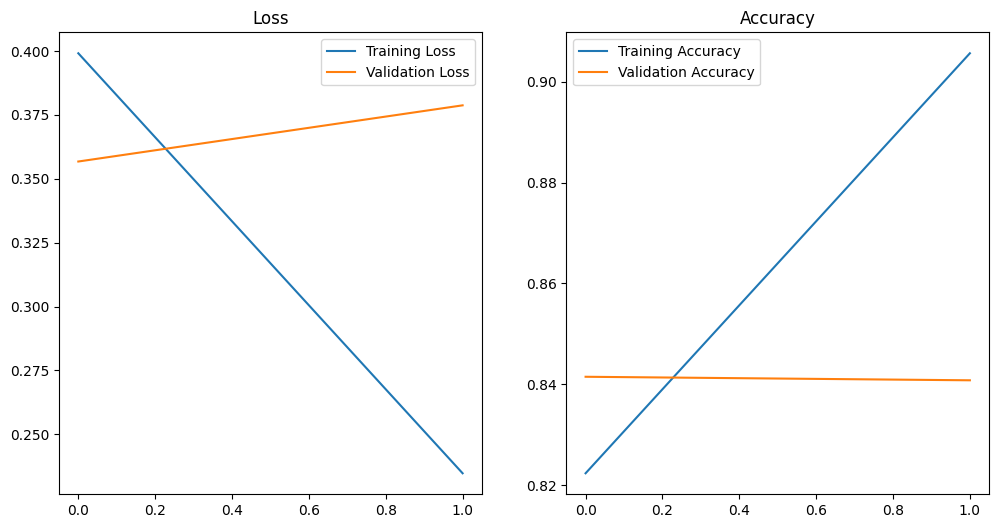

([0.3991282379746437, 0.23475976756115755],
 [0.35676870819330214, 0.37875494560599327],
 [0.8223666666666667, 0.9056333333333333],
 [0.8415, 0.8408])

In [125]:
# Model 1 w/ Pooling
modelLast = SentimentClassifierLast(n_classes=1)
modelLast = modelLast.cuda()
train_model(modelLast,  train_data_loader, valid_data_loader, epochs=2, lr=0.0001,model_name="first try")


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 1:
Training loss: 0.6657071494102478, Accuracy: 0.6013
Validation loss: 0.6374954526901245, Accuracy: 0.6588
Saved best accuracy model as firstPooled_best_acc.pth
Saved best loss model as firstPooled_best_loss.pth


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 2:
Training loss: 0.6354193474292755, Accuracy: 0.6549
Validation loss: 0.6126239959716797, Accuracy: 0.6886
Saved best accuracy model as firstPooled_best_acc.pth
Saved best loss model as firstPooled_best_loss.pth


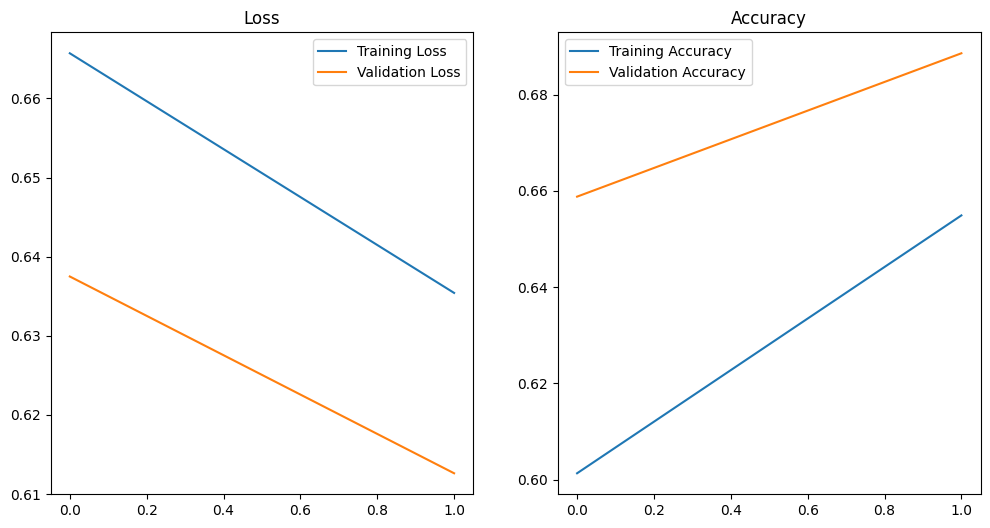

([0.6657071494102478, 0.6354193474292755],
 [0.6374954526901245, 0.6126239959716797],
 [0.6013, 0.6549],
 [0.6588, 0.6886])

In [126]:
# Model 1 w/ Pooling
modelPool = SentimentClassifierPooled(n_classes=1)
modelPool = modelPool.cuda()
train_model(modelPool,  train_data_loader, valid_data_loader, epochs=2, lr=0.0001,model_name="firstPooled")

### Part (iii) [1pt MODEL]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters. You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 1:
Training loss: 0.4038044635097186, Accuracy: 0.8209666666666666
Validation loss: 0.3493254047513008, Accuracy: 0.8422
Saved best accuracy model as modelLast2_best_acc.pth
Saved best loss model as modelLast2_best_loss.pth


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 2:
Training loss: 0.2308153891583284, Accuracy: 0.9096333333333333
Validation loss: 0.3937381947547197, Accuracy: 0.8416


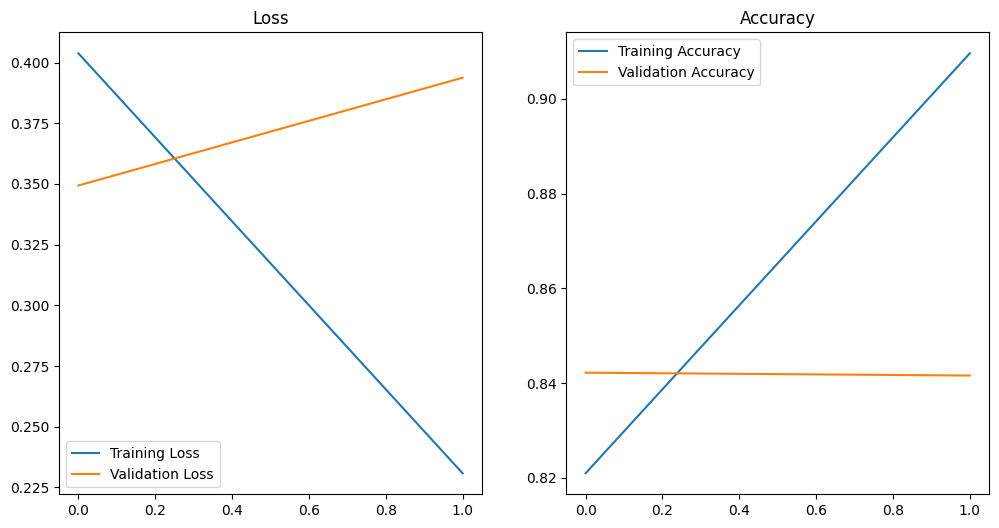

([0.4038044635097186, 0.2308153891583284],
 [0.3493254047513008, 0.3937381947547197],
 [0.8209666666666666, 0.9096333333333333],
 [0.8422, 0.8416])

In [127]:
modelLast2 = SentimentClassifierLast(n_classes=1)
modelLast2 = modelLast2.cuda()
train_model(modelLast2,  train_data_loader, valid_data_loader, epochs=2, lr=0.0001,model_name="modelLast2")

  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 1:
Training loss: 0.605137454032898, Accuracy: 0.6658666666666667
Validation loss: 0.5918936849594116, Accuracy: 0.6815
Saved best accuracy model as model_best_acc.pth
Saved best loss model as model_best_loss.pth


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 2:
Training loss: 0.5445231336434683, Accuracy: 0.7244333333333334
Validation loss: 0.5348955852031708, Accuracy: 0.7312
Saved best accuracy model as model_best_acc.pth
Saved best loss model as model_best_loss.pth


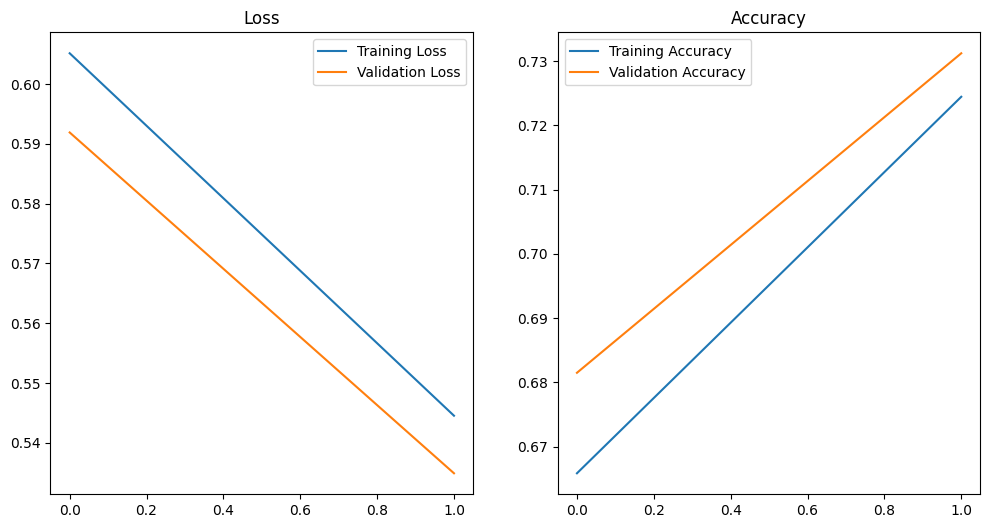

([0.605137454032898, 0.5445231336434683],
 [0.5918936849594116, 0.5348955852031708],
 [0.6658666666666667, 0.7244333333333334],
 [0.6815, 0.7312])

In [131]:
class SentimentClassifierLast3(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifierLast3, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        # Keep BERT parameters frozen
        for param in self.bert.parameters():
            param.requires_grad = False
        
        # Add an extra linear layer
        self.fc1 = nn.Linear(768, 1024)  # First linear layer
        self.fc2 = nn.Linear(1024, 256)  # Additional linear layer
        self.fc3 = nn.Linear(256, n_classes)  # Final layer to match the number of classes

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Assuming use of pooled output for classification
        output = bert_output.pooler_output
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)  # Assuming BCEWithLogitsLoss will be used
        return output.squeeze()

modelLast3 = SentimentClassifierLast3(n_classes=1)
modelLast3 = modelLast3.cuda()
train_model(modelLast3,  train_data_loader, valid_data_loader, epochs=2, lr=0.0001)


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 1:
Training loss: 0.6016255677541097, Accuracy: 0.6692333333333333
Validation loss: 0.573237335729599, Accuracy: 0.6958
Saved best accuracy model as model_best_acc.pth
Saved best loss model as model_best_loss.pth


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 2:
Training loss: 0.5441086041609446, Accuracy: 0.7259333333333333
Validation loss: 0.5054152872085571, Accuracy: 0.7564
Saved best accuracy model as model_best_acc.pth
Saved best loss model as model_best_loss.pth


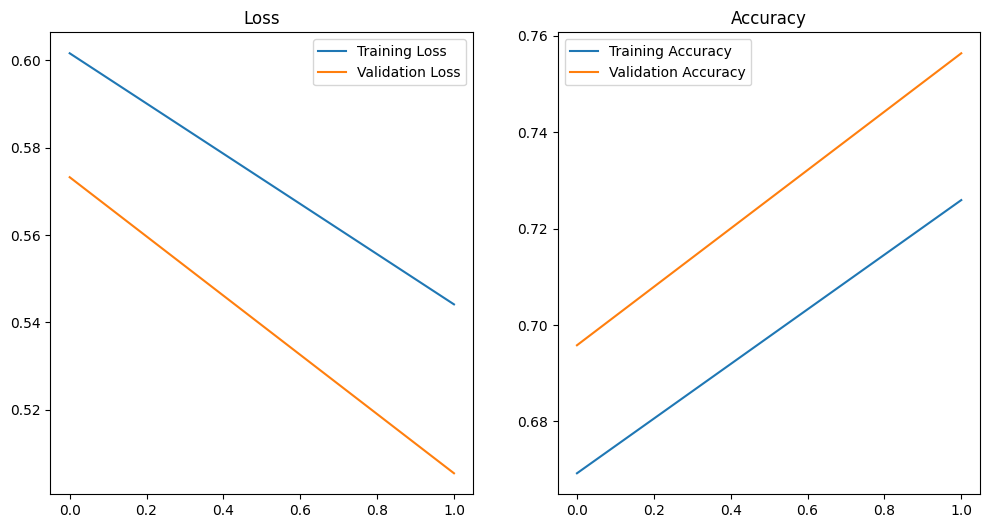

([0.6016255677541097, 0.5441086041609446],
 [0.573237335729599, 0.5054152872085571],
 [0.6692333333333333, 0.7259333333333333],
 [0.6958, 0.7564])

In [132]:

class SentimentClassifierLast4(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifierLast4, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        # Keep BERT parameters frozen
        for param in self.bert.parameters():
            param.requires_grad = False
        
        self.fc1 = nn.Linear(768, 1024)  # Adjust the size as per your model design
        self.fc2 = nn.Linear(1024, 256)  # Second linear layer
        self.fc3 = nn.Linear(256, n_classes)  # Output layer to match the number of classes

        # Define an activation function
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        output = bert_output.pooler_output
        output = self.leaky_relu(self.fc1(output))
        output = self.leaky_relu(self.fc2(output))
        output = self.fc3(output)  # No activation here if using with BCEWithLogitsLoss
        return output.squeeze()

modelLast4 = SentimentClassifierLast4(n_classes=1)
modelLast4 = modelLast4.cuda()
train_model(modelLast4,  train_data_loader, valid_data_loader, epochs=2, lr=0.0001)

  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 1:
Training loss: 0.6007472658793132, Accuracy: 0.6740333333333334
Validation loss: 0.5548750972270966, Accuracy: 0.7093
Saved best accuracy model as model_best_acc.pth
Saved best loss model as model_best_loss.pth


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 2:
Training loss: 0.5434261267185211, Accuracy: 0.7286
Validation loss: 0.5275518554210663, Accuracy: 0.7329
Saved best accuracy model as model_best_acc.pth
Saved best loss model as model_best_loss.pth


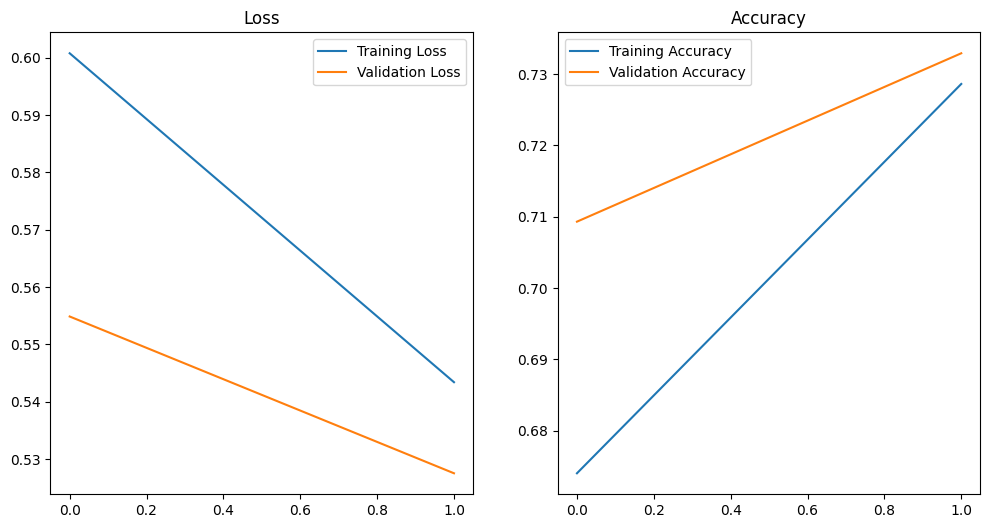

([0.6007472658793132, 0.5434261267185211],
 [0.5548750972270966, 0.5275518554210663],
 [0.6740333333333334, 0.7286],
 [0.7093, 0.7329])

In [133]:

class SentimentClassifierLast5(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifierLast5, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        # Keep BERT parameters frozen
        for param in self.bert.parameters():
            param.requires_grad = False
        
        # Define additional linear layers with different sizes
        self.fc1 = nn.Linear(768, 1024)  # Adjust the size as needed
        self.fc2 = nn.Linear(1024, 512)  # New additional linear layer
        self.fc3 = nn.Linear(512, 256)   # Another additional linear layer
        self.fc4 = nn.Linear(256, n_classes)  # Output layer to match the number of classes

        # Define an activation function for each layer
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Use the pooled output from BERT as the input to the neural network
        output = bert_output.pooler_output
        output = self.leaky_relu(self.fc1(output))
        output = self.leaky_relu(self.fc2(output))
        output = self.leaky_relu(self.fc3(output))
        output = self.fc4(output)  # No activation function before the loss calculation
        return output.squeeze()

modelLast5 = SentimentClassifierLast5(n_classes=1)
modelLast5 = modelLast5.cuda()
train_model(modelLast5,  train_data_loader, valid_data_loader, epochs=2, lr=0.0001)

  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 1:
Training loss: 0.40884220349788664, Accuracy: 0.8204
Validation loss: 0.3504759153008461, Accuracy: 0.8451
Saved best accuracy model as modelFinalBert_best_acc.pth
Saved best loss model as modelFinalBert_best_loss.pth


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 2:
Training loss: 0.2670220575603346, Accuracy: 0.8969
Validation loss: 0.41265406948626043, Accuracy: 0.8366


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 3:
Training loss: 0.1793242731363823, Accuracy: 0.9288333333333333
Validation loss: 0.4262531295135617, Accuracy: 0.8443


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 4:
Training loss: 0.15751959739817928, Accuracy: 0.9395
Validation loss: 0.5123150270849466, Accuracy: 0.8344


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 5:
Training loss: 0.12324949190977495, Accuracy: 0.9570666666666666
Validation loss: 0.4510079134553671, Accuracy: 0.8533
Saved best accuracy model as modelFinalBert_best_acc.pth


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 6:
Training loss: 0.08681029596494433, Accuracy: 0.9683333333333334
Validation loss: 0.8603268336459994, Accuracy: 0.7899


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 7:
Training loss: 0.06186930666519911, Accuracy: 0.9771666666666666
Validation loss: 0.6763360565174371, Accuracy: 0.8397


  0%|          | 0/1875 [00:00<?, ?it/s]/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

Epoch 8:
Training loss: 0.06036163308041845, Accuracy: 0.9780666666666666
Validation loss: 0.5836347054347396, Accuracy: 0.8498


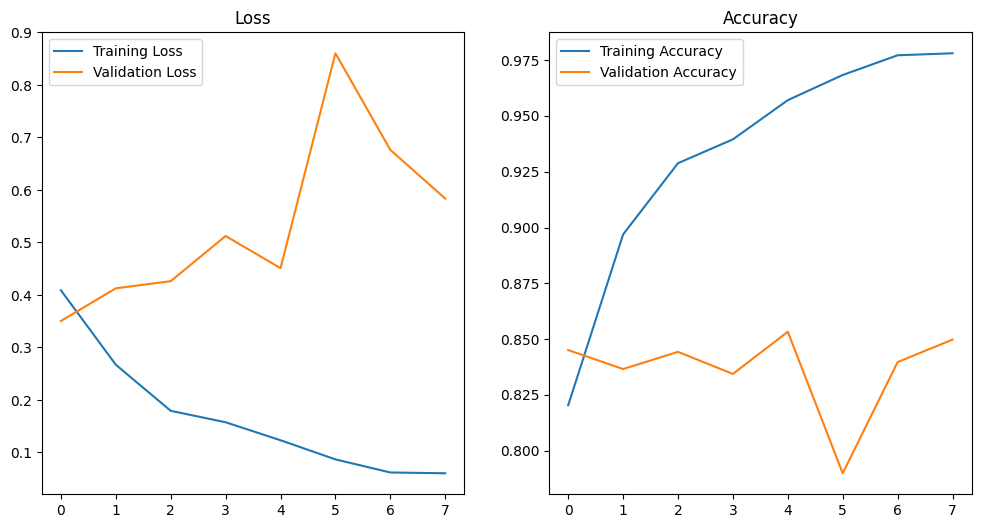

([0.40884220349788664,
  0.2670220575603346,
  0.1793242731363823,
  0.15751959739817928,
  0.12324949190977495,
  0.08681029596494433,
  0.06186930666519911,
  0.06036163308041845],
 [0.3504759153008461,
  0.41265406948626043,
  0.4262531295135617,
  0.5123150270849466,
  0.4510079134553671,
  0.8603268336459994,
  0.6763360565174371,
  0.5836347054347396],
 [0.8204,
  0.8969,
  0.9288333333333333,
  0.9395,
  0.9570666666666666,
  0.9683333333333334,
  0.9771666666666666,
  0.9780666666666666],
 [0.8451, 0.8366, 0.8443, 0.8344, 0.8533, 0.7899, 0.8397, 0.8498])

In [134]:
modelFinalBert = SentimentClassifierLast(n_classes=1) #! the original actually seems to have the lowest loss and best accuracy so I will use that and increase number of epochs as the fifth fine tuning param. 
modelFinalBert = modelFinalBert.cuda()
train_model(modelFinalBert,  train_data_loader, valid_data_loader, epochs=8, lr=0.0001,model_name="modelFinalBert")

In [ ]:
'''
The hyperparameters I tuned
1)use of activation functions 
2) epochs
3) layer size
4) type of BERT application 

Activation Functions:
After experimentation, I found that using Leaky ReLU activation function yielded the best results for  sentiment analysis model.

Epochs:
Increasing the number of epochs improved the performance of the model. However, need to increase epochs more to check for convergence since it was still increasing however I lack the computing power needed. 

Layer Size:
I did this to add complexity so it can better capture the dataset we are using.

Lastly, for the type of BERT application I mean I exprimented with both pooling and using Last, however I think pooling make it generlize too much and averages so im getting better results with using the last layer. 


'''

## Part 4. Evaluation [10 pt]

### Part (i) [3pt RESULT]

Report the final test accuracy of your best BERT-based model. Then summarize in a pandas dataframe the accuracy obtained on the training, validation, and test data of your best models from Part A and B.

How does the BERT model compare to the approach in part A using only LSTM? Are the results what you expected? Explain.



In [ ]:
finalModel = finalModel.cuda()
checkpoint = torch.load("checkpoints/finalModel/model_epoch_5.pth")
finalModel.load_state_dict(checkpoint['model_state_dict'])

test_loader = DataLoader(dataset=test, batch_size=64)
accuracy = get_accuracy(finalModel, test_loader)
print("Test Accuracy:", accuracy)


Training loss: 0.06036163308041845, Accuracy: 0.9780666666666666
Validation loss: 0.5836347054347396, Accuracy: 0.8498

In [145]:
import torch
from sklearn.metrics import accuracy_score


modelFinalBert = SentimentClassifierLast(n_classes=1)
modelFinalBert = modelFinalBert.cuda()  
modelFinalBert.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_data_loader:
        inputs = batch['input_ids'].cuda() 
        attention_mask = batch['attention_mask'].cuda()  
        labels = batch['targets'].cuda() 
        outputs = modelFinalBert(inputs, attention_mask=attention_mask)
        if isinstance(outputs, tuple):
            logits = outputs[0]
        else:
            logits = outputs  
        predictions = torch.round(torch.sigmoid(logits)).cpu().numpy().flatten().tolist()
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy().flatten().tolist())
accuracy = accuracy_score(all_labels, all_predictions)
print("Test Accuracy:", accuracy)


/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/souren/anaconda3/envs/mie1517/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

Test Accuracy: 0.495


In [146]:
import pandas as pd

data_list = [
    ['Best LSTM ', 0.9811, 0.8442, 0.8477],
    ['Best BERT ', 0.9780, 0.8498, 0.495],

]

columns = ['Model', 'Training Accuracy', 'Validation Accuracy', 'Test Accuracy']
df = pd.DataFrame(data_list, columns=columns)
print("Performance of Language Models\n")
print(df)


Performance of Language Models

        Model  Training Accuracy  Validation Accuracy  Test Accuracy
0  Best LSTM              0.9811               0.8442         0.8477
1  Best BERT              0.9780               0.8498         0.4950


In [ ]:
'''
The Bert model is performing worse, even than in training by big margin, might be some error to how the file is saved, but I am out of google collab credits to re run training. However it should outperform the models we made because it is trained
based on a much larger dataset. 
Also bert was trained on prediction and not classification, so it might not either 1) have a good understanding of semantics and just uses probability to predict next token and so it is not suitable for what we want to do. 
Moreover, BERT is frozen, so it wont be able to further generalize.
Lastly, as I mentioned very compute heavy and simply cannot afford to let training converge and properly experiment. 






'''

### Part (ii) [2pt RESULT]

Report the false positive rate and false negative rate of your model across the test set. Then summarize in a pandas dataframe the false postive and false negative rate of your model obtained on the training, validation, and test data of your best models from Part A and B.

How does the BERT model compare to the approach in part A using only LSTM? Are the results what you expected? Explain.

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

def evaluate_fp_fn(model, loader):
    model.eval()
    labels, preds = [], []
    for batch in loader:
        data, targets = batch['input_ids'].cuda(), batch['attention_mask'].cuda()
        output = model(data, attention_mask=targets)
        predictions = (output > 0.0).squeeze().long()
        labels += batch['targets'].long().tolist()
        preds += predictions.tolist()

    tn, fp, fn, tp = confusion_matrix(y_true=labels, y_pred=preds).ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    return fpr, fnr


# Evaluate BERT model
print("BERT Model Results:")
fpr_bert_train, fnr_bert_train = evaluate_fp_fn(modelFinalBert, train_data_loader)
fpr_bert_valid, fnr_bert_valid = evaluate_fp_fn(modelFinalBert, valid_data_loader)
fpr_bert_test, fnr_bert_test = evaluate_fp_fn(modelFinalBert, test_data_loader)

# Evaluate LSTM model from Part A
print("\nLSTM Model Results:")
fpr_lstm_train, fnr_lstm_train = evaluate_fp_fn(finalModel, train_data_loader)
fpr_lstm_valid, fnr_lstm_valid = evaluate_fp_fn(finalModel, valid_data_loader)
fpr_lstm_test, fnr_lstm_test = evaluate_fp_fn(finalModel, test_data_loader)

# Create pandas dataframe to summarize results
data_list = [
    ['BERT', fpr_bert_train, fnr_bert_train, fpr_bert_valid, fnr_bert_valid, fpr_bert_test, fnr_bert_test],
    ['LSTM (Part A)', fpr_lstm_train, fnr_lstm_train, fpr_lstm_valid, fnr_lstm_valid, fpr_lstm_test, fnr_lstm_test],
]
df = pd.DataFrame(data_list, columns=['Model', 'Train FPR', 'Train FNR', 'Valid FPR', 'Valid FNR', 'Test FPR', 'Test FNR'])

print("\nSummary of False Positive Rate (FPR) and False Negative Rate (FNR) for BERT and LSTM:")
print(df)


In [ ]:
'''
The 






'''

### Part (iii) [3pt DISCUSSION]
Examine some of the misclassified reviews from you best BERT and LSTM models to better identify the differences in the models. Try to provide some justification for any differences in the misclassifications observed in the models.

Is there any part of the review that you could modify to make the classifications correct? Try to make small changes to the review to see if you can make the model make the correct classification while keeping the review as close to the original as possible.

In [ ]:
def examine_misclassifications(model, data_loader):
    model.eval()
    misclassified_reviews = []
    for batch in data_loader:
        data, targets = batch['input_ids'].cuda(), batch['attention_mask'].cuda()
        outputs = model(data, attention_mask=targets)
        predictions = (outputs > 0.0).squeeze().long()
        for i in range(len(predictions)):
            if predictions[i] != targets[i]:
                review = batch['review'][i]  
                true_label = targets[i].item()
                predicted_label = predictions[i].item()
                misclassified_reviews.append({'Review': review, 'True Label': true_label, 'Predicted Label': predicted_label})
    return pd.DataFrame(misclassified_reviews)

misclassified_bert_df = examine_misclassifications(modelFinalBert, test_data_loader)

# Get misclassified reviews for LSTM model from Part A
misclassified_lstm_df = examine_misclassifications(finalModel, test_data_loader)


print("Misclassified Reviews for BERT Model:")
print(misclassified_bert_df.head())

print("\nMisclassified Reviews for LSTM Model (Part A):")
print(misclassified_lstm_df.head())



In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part (iv) [2pt DISCUSSION]
Find 5 samples of positive and negative reviews on IMDB that were posted recently and evaluate them with your best BERT and LSTM models from parts A and B. How well do they perform?

In [ ]:
rev1="""Poor Things simply just wasn't for me. I really don't like to say I hate a movie... so we'll just go with "it wasn't for me". I did appreciate the production design and performances, but a lot of the cinematography and writing/directing choices just didn't work for me. Just a little too weird for my tastes. And felt way too long. I wanted to like it so bad, and was so disappointed to find myself disliking it so much.

I know it's been getting good reviews from most people - I'm in the minority here! So if you're interested, definitely check it out! I'm a huge supporter of going to see a film if you are interested in it and deciding for yourself how you feel!"""

rev2="""While I am loathe to criticise a fairly original story and something quite different from the norm, this film was definitely not for me. I'm a big fan of Stone, Ruffalo and Defoe so it pains me even more to be negative but I did not like this at all and feel tricked by the high review scores, to the point where I feel the need to leave a low score to balance it out a bit.

I was left thinking suddenly I no longer understand film for this to have scored so high.

I'm not sure why this is deemed a comedy, it is much more a horror in the conventional sense. Frequently grotesque and music designed to make you want to hit the mute button. I tried to like the style and cinematography but I just found the whole story so unpleasant as to be completely distracting.

The one thing I did find funny was the first frame saying 'CONTAINS TOBACCO REFERENCES', which is then proceeded by the opening shot of a suicide. What a bizarre world we are living in.
"""

rev3="""Bella Baxter is a woman with the mind of a child- literally. The product of a Frankensteinesque experiment by eccentric surgeon Godwin Baxter, Bella has spent all her life locked in his mansion, surrounded by his other creations. After Godwin hires medical student Max McCandles to be his assistant, Bella begins to develop, her intelligence increasing rapidly. Craving autonomy and wanting to see the world, Bella decides to travel with Godwin's slick lawyer Duncan Wedderburn, although life outside the mansion proves to be strange and harsh; and Duncan's charm only skin deep."""

rev4="""You'll have to have your wits about you and your brain fully switched on watching Oppenheimer as it could easily get away from a nonattentive viewer. This is intelligent filmmaking which shows it's audience great respect. It fires dialogue packed with information at a relentless pace and jumps to very different times in Oppenheimer's life continuously through it's 3 hour runtime. There are visual clues to guide the viewer through these times but again you'll have to get to grips with these quite quickly. This relentlessness helps to express the urgency with which the US attacked it's chase for the atomic bomb before Germany could do the same. An absolute career best performance from (the consistenly brilliant) Cillian Murphy anchors the film. This is a nailed on Oscar performance. In fact the whole cast are fantastic (apart maybe for the sometimes overwrought Emily Blunt performance). RDJ is also particularly brilliant in a return to proper acting after his decade or so of calling it in. The screenplay is dense and layered (I'd say it was a thick as a Bible), cinematography is quite stark and spare for the most part but imbued with rich, lucious colour in moments (especially scenes with Florence Pugh), the score is beautiful at times but mostly anxious and oppressive, adding to the relentless pacing. The 3 hour runtime flies by. All in all I found it an intense, taxing but highly rewarding watch. This is film making at it finest. A really great watch."""

rev5="""I may consider myself lucky to be alive to watch Christopher Nolan Works which get better by years.

Oppenheimer is - with no doubt- going to be one of the best movies in the history. Amazing cinematography, Exceptional acting and terrifying Soundtracks.

All the cast are great from cilian Murphy who is going for the oscar with this role to Rupert Downey jr and Emily blunt and finally rami malik who has small scenes but you will never forget them.

I didn't watch it in Imax as i couldn't wait and ran to the nearest cinema but now i will sure book an imax ticket.

Don't waste any time, book your ticket and Go watch it.. NOW."""


In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

# PART C (Optional) - Bonus Challenge!

This is an optional exercise for those that finish the assignment early and would like to take on a challenging task.

In part A we constructed and trained an LSTM model to identify the sentiment in movie reviews. In Part B we used the embeddings of a BERT model pretrained on a large corpus of text to demonstrate how transfer learning can be used to improve our movie sentiment model. The BERT model is one of many language models that we could have used to implement transfer learning.

For this bonus challenge you are asked to implement a generative character-level LSTM model to produce IMDB movie reviews. Once the model is sufficiently trained you can then use its hidden states as the embedding for training a movie sentiment model. Construct your new movie sentiment analysis model and compare the performance against the model from part A and B.

There are many variants of a generative LSTM model that you can consider. As a starting point you can use the generative LSTM sample code provided in the lecture notes. Specifically, the one used to generate Shakeaspeare. More advanced versions of a generative LSTM can be found in the Universal Language Model Fine-turing for Text Classification (ULMfit) paper (https://arxiv.org/abs/1801.06146).

Tasks:

1. Create a generative character-level LSTM model trained to create IMDB reviews
2. Create a classifier using the embeddings from the generative LSTM model (from step 1) to identify positive and negative reviews.
3. Compare the performance of the model with the results in parts A and B of the assignment.
4. Upgrade the generative LSTM model using the techniques listed in the ULMfit paper (e.g., bi-directional LSTM, pretraining with wikipedia text and fine-tuning on IMDBT reviews, etc.).

Bonus marks will be provided based on the number of steps completed. Summarize below your results and anything intersting you learned from the steps that you completed. Bonus marks cannot be accumulated beyond a maximum assignment grade.


In [ ]:
# TO BE COMPLETED




In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [150]:
jupyter nbconvert --to html A4.ipynb



SyntaxError: invalid syntax (1428962757.py, line 1)

(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus

# Assignment Grading Rubric
The grading of the assignment will be based on the following categories:

(1) **10 Pt - EXPLORATORY QUESTIONS** These are basic questions that in most cases can be answered without requiring a fully working and trained neural network model. For example, data loading, processing and visualization, summary statistics, data exploration, model and training setup, etc.

(2) **10 Pt - MODEL** Student has successfully implemented all the required neural network models and has demonstrated successful training of the model without any errors.

(3) **10 Pt - RESULT** Students are evaluated based on the results achieved in comparison to the expected results of the assignment.

(4) **10 Pt - DISCUSSION QUESTIONS** Student demonstrated understanding beyond the basic exploratory questions, can answer some of the more challenging questions, and provide arguments for their model selection decisions.

(5) **10 Pt - COMMUNICATION** Student has provided a quality submission that is easy to read without too many unnecessary output statements that distract the reading of the document. The code has been well commented and all the answers are communicated clearly and concisely.

(6) **10 Pt - BONUS** Student has completed the assignment and has taken on the challenging bonus tasks listed in PART C. The student has demonstrated a good understanding of all aspects of the assignment and has exceeded expectations for the assignment.



**TOTAL GRADE = _____ of 50 Pts**